In [2]:
# import the standard stuff...

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
#  Read in the data which is in  exel format.   

df = pd.read_excel("globalterrorismdb_0616dist.xlsx", sheetname=0)


In [4]:
# take a peak at what we have.

df.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,0,0,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [6]:
# How much stuff is there?  

df.shape

(156772, 137)

In [7]:
# some standard EDA to see what we have in terms of nulls, objects, floats, integers etc.  

def eda(dataframe):
    print dataframe.dtypes
    print dataframe.describe()
    print dataframe.describe(include='all')
    print dataframe.isnull().sum()
    print dataframe.index
    print dataframe.head()
    print dataframe.tail()
    print dataframe.corr(method='pearson', min_periods=1)
print eda(df)

eventid                 int64
iyear                   int64
imonth                  int64
iday                    int64
approxdate             object
extended                int64
resolution             object
country                 int64
country_txt            object
region                  int64
region_txt             object
provstate              object
city                   object
latitude              float64
longitude             float64
specificity             int64
vicinity                int64
location               object
summary                object
crit1                   int64
crit2                   int64
crit3                   int64
doubtterr             float64
alternative           float64
alternative_txt        object
multiple                int64
success                 int64
suicide                 int64
attacktype1             int64
attacktype1_txt        object
                       ...   
propextent            float64
propextent_txt         object
propvalue 

/Users/user/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


            eventid          iyear         imonth           iday  \
count  1.567720e+05  156772.000000  156772.000000  156772.000000   
mean   2.000541e+11    2000.474083       6.484666      15.455215   
std    1.298283e+09      12.982397       3.392225       8.815533   
min    1.970000e+11    1970.000000       0.000000       0.000000   
25%    1.989082e+11    1989.000000       4.000000       8.000000   
50%    2.005071e+11    2005.000000       6.000000      15.000000   
75%    2.013060e+11    2013.000000       9.000000      23.000000   
max    2.015123e+11    2015.000000      12.000000      31.000000   

            extended        country         region       latitude  \
count  156772.000000  156772.000000  156772.000000  152253.000000   
mean        0.041347     133.087401       6.970097      23.190988   
std         0.199091     113.946290       2.967803      19.220723   
min         0.000000       4.000000       1.000000     -53.154613   
25%         0.000000      69.000000       

In [9]:
#  list the columns.

df.columns

Index([u'eventid', u'iyear', u'imonth', u'iday', u'approxdate', u'extended',
       u'resolution', u'country', u'country_txt', u'region',
       ...
       u'addnotes', u'scite1', u'scite2', u'scite3', u'dbsource', u'INT_LOG',
       u'INT_IDEO', u'INT_MISC', u'INT_ANY', u'related'],
      dtype='object', length=137)

In [65]:
# make a data frame of year, country code, country, type of attack code and type of attack, success, and number of kills

df[['iyear','country','country_txt','attacktype1','attacktype1_txt','success','nkillus']].head(15)

,iyear,country,country_txt,attacktype1,attacktype1_txt,success,nkillus
0,1970,58,Dominican Republic,1,Assassination,1,NaN
1,1970,130,Mexico,6,Hostage Taking (Kidnapping),1,NaN
2,1970,160,Philippines,1,Assassination,1,NaN
3,1970,78,Greece,3,Bombing/Explosion,1,NaN
4,1970,101,Japan,7,Facility/Infrastructure Attack,1,NaN
5,1970,217,United States,2,Armed Assault,1,0.0
6,1970,218,Uruguay,1,Assassination,0,NaN
7,1970,217,United States,3,Bombing/Explosion,1,0.0
8,1970,217,United States,7,Facility/Infrastructure Attack,1,0.0
9,1970,217,United States,7,Facility/Infrastructure Attack,1,0.0


In [198]:
# Data frame with year, country, and types of attacks.   

df[['iyear','country','country_txt','attacktype1','attacktype1_txt']].head(50)

,iyear,country,country_txt,attacktype1,attacktype1_txt
0,1970,58,Dominican Republic,1,Assassination
1,1970,130,Mexico,6,Hostage Taking (Kidnapping)
2,1970,160,Philippines,1,Assassination
3,1970,78,Greece,3,Bombing/Explosion
4,1970,101,Japan,7,Facility/Infrastructure Attack
5,1970,217,United States,2,Armed Assault
6,1970,218,Uruguay,1,Assassination
7,1970,217,United States,3,Bombing/Explosion
8,1970,217,United States,7,Facility/Infrastructure Attack
9,1970,217,United States,7,Facility/Infrastructure Attack


In [41]:
# Write some booleans to filter and look at different acts of terror in different countries.   USA is 217  

# filter assinations ...in the USA .... 
df[(df.attacktype1 ==1) & (df.country == 217)]

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
111,197003050003,1970,3,5,NaN,0,NaN,217,United States,1,...,Conflicting reports attribute the incident to ...,Committee on the Judiciary United States Sena...,"William Sater, ""Puerto Rican Terrorists: A Pos...","""Toward People's War for Independence and Soci...",Hewitt Project,0,1,0,1,NaN
142,197003200002,1970,3,20,NaN,0,NaN,217,United States,1,...,The police were unsure if this incident was an...,"Jerry M. Flint, ""Civil Rights Chief In Michiga...","""No Motive of Suspect Seen In Slaying of Right...","Marcia McKnight Trick, ""Chronology of Incident...",Hewitt Project,-9,-9,0,-9,NaN
225,197004240004,1970,4,24,NaN,0,NaN,217,United States,1,...,Huang and Cheng Tzu-tsai were arrested but jum...,"“Taiwan: A Shot at Chiang.” Time Magazine, May...",“Failed Assassin Vows to Pursue Independence f...,"Bodeen, Christopher. “Would Be Assassin Resurf...",Hewitt Project,0,1,1,1,NaN
319,197006020003,1970,6,2,NaN,0,NaN,217,United States,1,...,It is believed that a Chicago businessman was ...,Committee on Government Operations United Stat...,"Terry Burns, ""Probe Provides Insight Into Car-...","""Legislator's Car Bombed,"" New York Times, Jun...",Hewitt Project,-9,-9,0,-9,NaN
339,197006090008,1970,6,9,NaN,0,NaN,217,United States,1,...,The White mayoral candidate was Hugh Addonizio...,"Walter H. Waggoner, ""Negro Backing Addonizio T...","""Shotgun Blasts Are Fired Into Home Of Black C...",NaN,Hewitt Project,-9,-9,0,-9,NaN
395,197007040006,1970,7,4,NaN,0,NaN,217,United States,1,...,Allan Daly survived two weeks before finally s...,"""Nonstriker At Paper Succumbs To Wounds,"" Los ...","""Home of Nonstriking Printers Fire-Bombed; 6 E...","""Slayer Given Life Sentence,"" The Bulletin, De...",Hewitt Project,-9,-9,0,-9,NaN
428,197007260001,1970,7,26,NaN,0,NaN,217,United States,1,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,0,-9,NaN
461,197008150001,1970,8,15,NaN,0,NaN,217,United States,1,...,John Thomas was one of the accused perpetrator...,"""Mississippi White Cleared in Killing,"" New Yo...","""Kin of NAACP Lobbyist Mitchell Wins Balto Pri...","Christopher Hewitt, ""Political Violence and Te...",Hewitt Project,-9,-9,0,-9,NaN
816,197104170001,1971,4,17,NaN,0,NaN,217,United States,1,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
842,197104290005,1971,4,29,NaN,0,NaN,217,United States,1,...,Christopher Brian Cowsar was a former marine. ...,"""Bank, Store Bombed, Trucks Burned in L. A.,"" ...","""Recruiter Slain On Job, Hero Killed In Hold-U...","""Air Force Recruiter Stabbed,"" Lodi News-Senti...",Hewitt Project,-9,-9,0,-9,NaN


In [158]:
#  In the USA use a groupby statement to group all the death due to terror for each year.   

df[df.country==217][['iyear','nkillus']].groupby(df['iyear']).sum().head()

,iyear,nkillus
iyear,,
1970,921960,27.0
1971,486837,15.0
1972,126208,5.0
1973,114434,37.0
1974,185556,11.0


In [180]:
# find deaths in 1995 USA

df[(df.country==217) & (df.iyear == 1995)][['nkillus']]

,nkillus
58097,NaN
58098,NaN
58099,NaN
58114,NaN
58119,NaN
58140,NaN
58157,0.0
58225,0.0
58275,NaN
58276,NaN


In [1]:
df.loc[[58964]]

NameError: name 'df' is not defined

In [184]:
#Stats on domestic deaths (1970 to 2015) with 9-11 and OK City bombing.

df[df.country==217][['iyear','nkillus']].groupby(df['iyear']).sum()['nkillus'].describe()

count      45.000000
mean       74.933333
std       432.722061
min         0.000000
25%         0.000000
50%         3.000000
75%        11.000000
max      2908.000000
Name: nkillus, dtype: float64

In [191]:
#create data frame of US domestic deaths without 9-11 and then run the stats on that. 
US_dom_terr_deaths[2001]=0
no_911 = pd.DataFrame({'year' : US_dom_terr_deaths.keys() , 'deaths' : US_dom_terr_deaths.values() })
no_911.head(2)

,deaths,year
0,27.0,1970
1,15.0,1971


In [192]:
no_911['deaths'].describe()

count     45.000000
mean      10.311111
std       26.265967
min        0.000000
25%        0.000000
50%        3.000000
75%       10.000000
max      170.000000
Name: deaths, dtype: float64

<function matplotlib.pyplot.show>

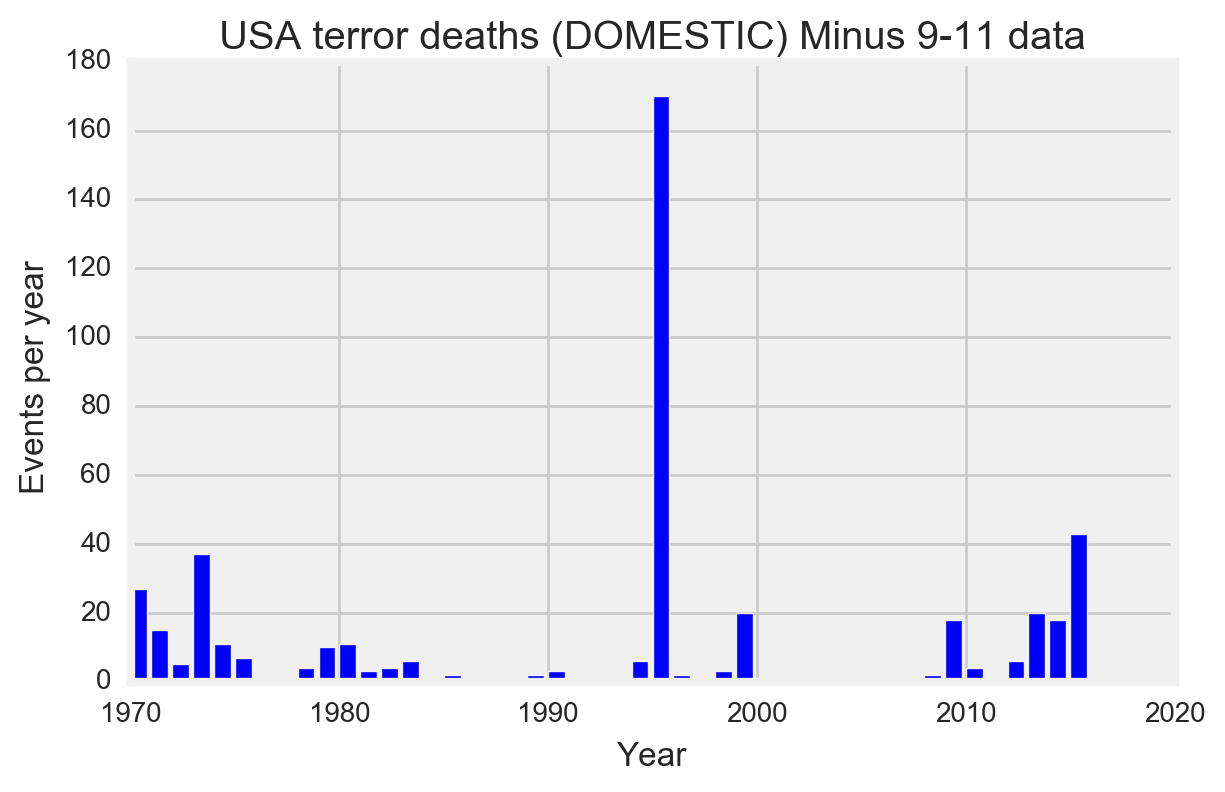

In [352]:
plt.bar(no_911['year'], no_911['deaths'], color='b')
plt.title(" USA terror deaths (DOMESTIC) Minus 9-11 data ")
plt.xlabel("Year")
plt.ylabel("Events per year ")
plt.savefig('Death (DOMESTIC) - 911.jpg')
plt.show

In [359]:
no_911.to_csv('no_911.csv',encoding='utf-8')

In [193]:
US_dom_terr_deaths[1995]

170.0

In [194]:
US_dom_terr_deaths[2001]=0
US_dom_terr_deaths[1995]=2
no_911_or_OK = pd.DataFrame({'year' : US_dom_terr_deaths.keys() , 'deaths' : US_dom_terr_deaths.values() })
no_911_or_OK['deaths'].describe()

count    45.000000
mean      6.577778
std       9.882236
min       0.000000
25%       0.000000
50%       2.000000
75%       7.000000
max      43.000000
Name: deaths, dtype: float64

In [364]:
print US_dom_terr_deaths[1992],US_dom_terr_deaths[1994]

0.0 6.0


In [169]:
# USA deaths that occured inside the USA due to terror put into a dictionary with year as key

US_dom_terr_deaths= df[df.country==217][['iyear','nkillus']].groupby(df['iyear']).sum()['nkillus'].to_dict()

US_dom_terr_deaths[2001]

2908.0

In [349]:
US_dom_terr_deaths[1985]

2.0

<function matplotlib.pyplot.show>

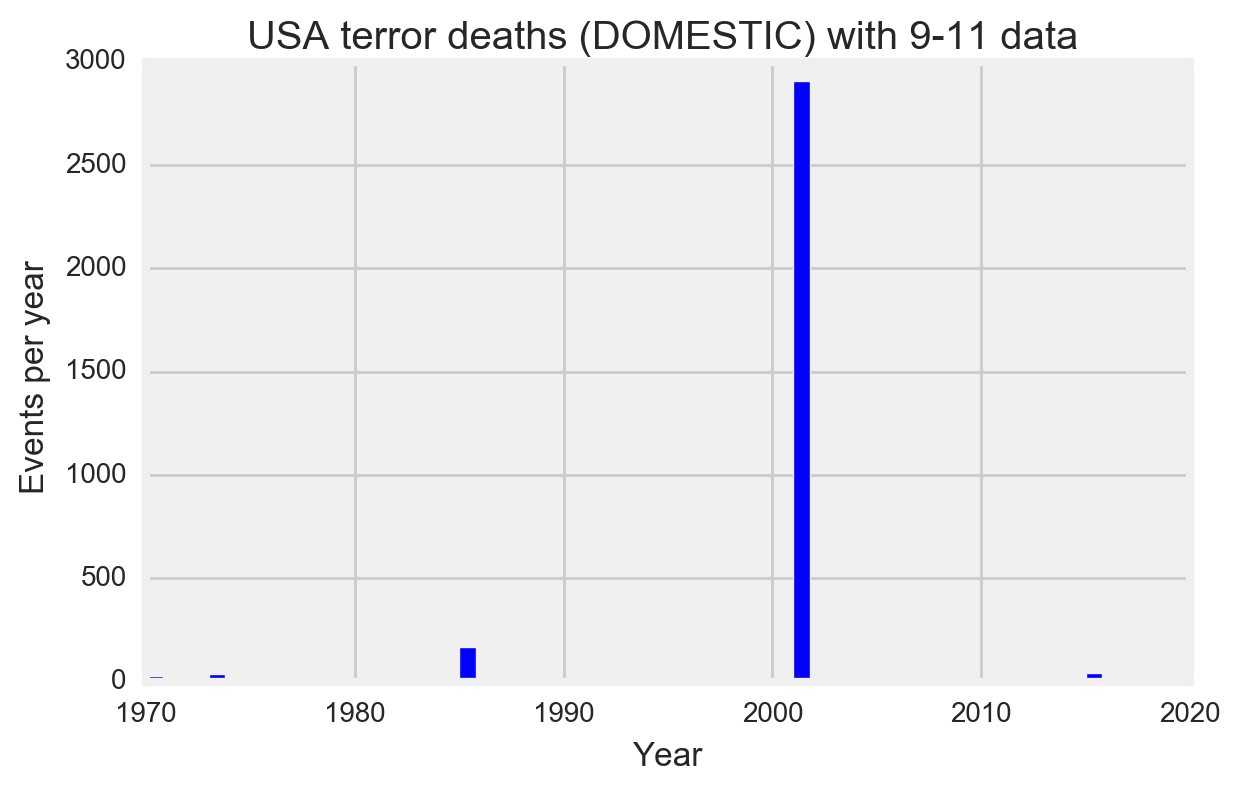

In [353]:
US_dom_terr_deaths[2001]=2908
US_dom_terr_deaths[1985]= 170
plt.bar(US_dom_terr_deaths.keys(), US_dom_terr_deaths.values(), color='b')
plt.title("USA terror deaths (DOMESTIC) with 9-11 data ")
plt.xlabel("Year")
plt.ylabel("Events per year ")
plt.savefig('Deaths (DOMESTIC) with 911.jpg')
plt.show

IOError: [Errno 2] No such file or directory: 'Deaths (DOMESTIC) without 911 w/o OK.jpg'

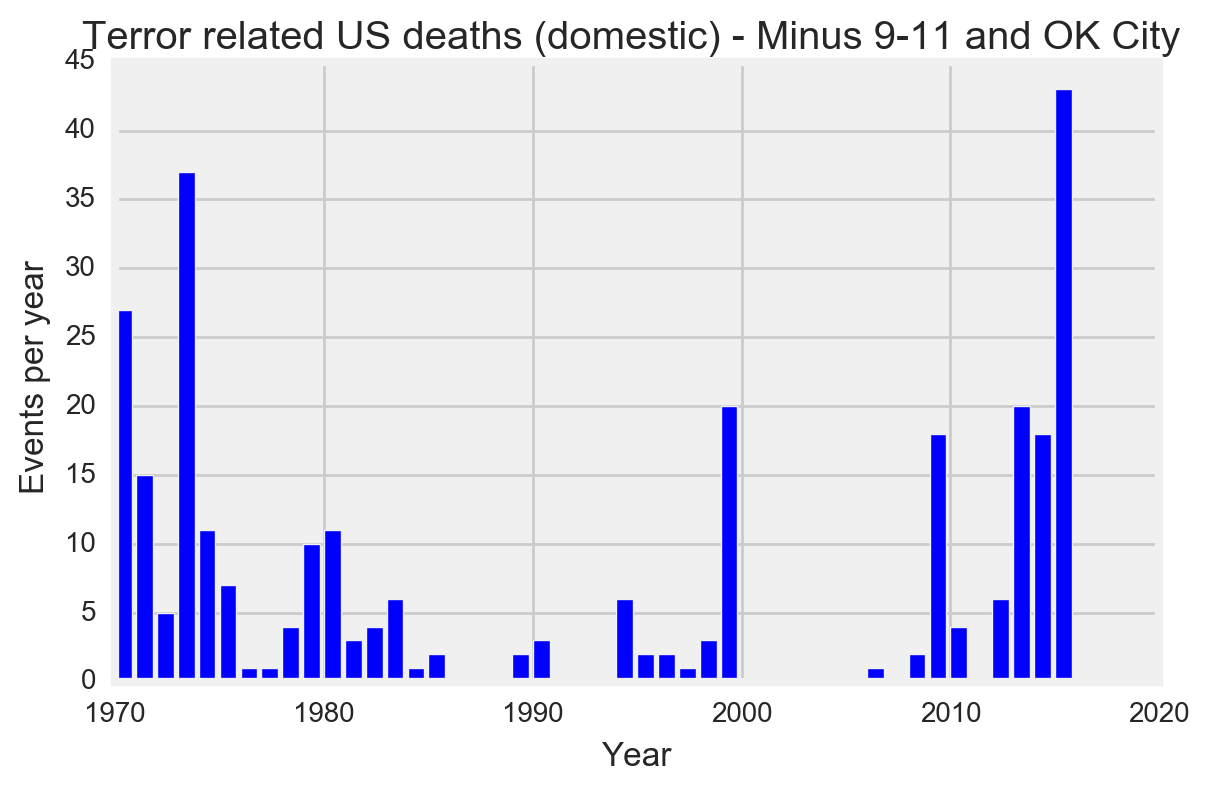

In [356]:
US_dom_terr_deaths[2001]=0
US_dom_terr_deaths[1985]=2
plt.bar(US_dom_terr_deaths.keys(), US_dom_terr_deaths.values(), color='b')
plt.title("Terror related US deaths (domestic) - Minus 9-11 and OK City ")
plt.xlabel("Year")
plt.ylabel("Events per year ")
plt.savefig('Deaths (DOMESTIC) without 911 w/o OK.jpg')
plt.show

In [358]:
df.to_csv('cowboy.csv',encoding='utf-8')

In [159]:
#df['nkillus'].groupby(df['iyear']).sum()

df[df.country==217][['iyear','nkillus']].head()

,iyear,nkillus
5,1970,0.0
7,1970,0.0
8,1970,0.0
9,1970,0.0
10,1970,NaN


In [160]:
# assinations, in the USA occurances in years
#df[(df.nkillus >=0) & (df.country == 217)]



<function matplotlib.pyplot.show>

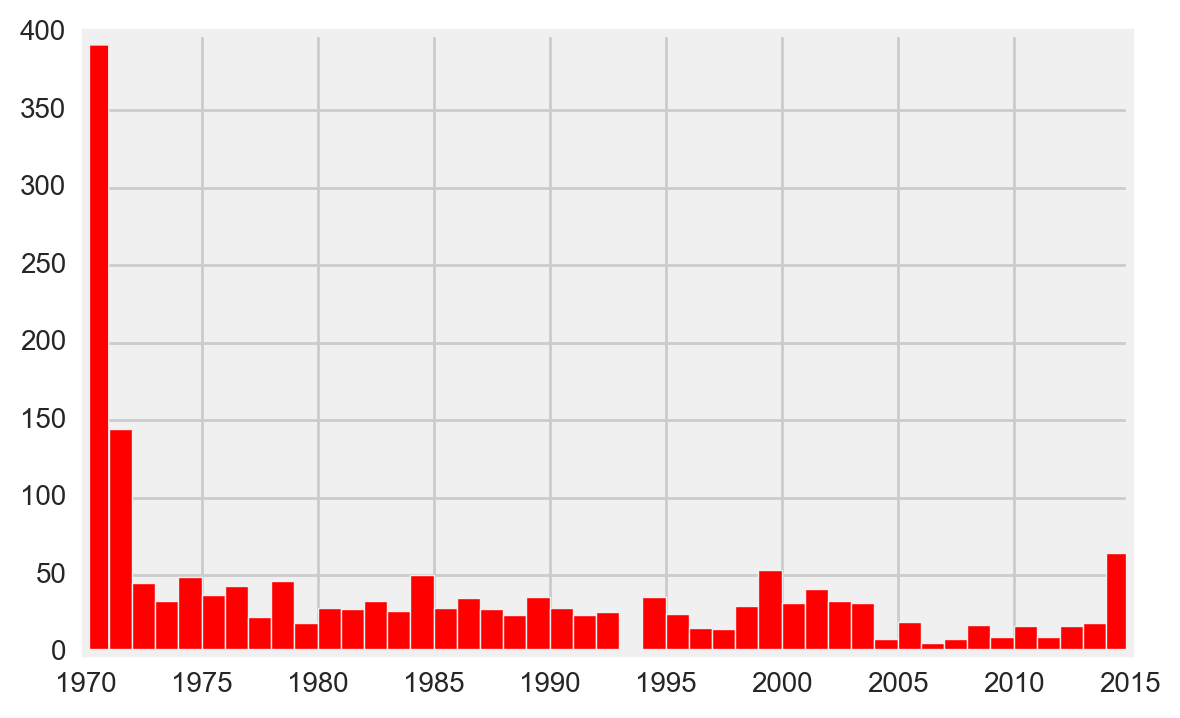

In [164]:
plt.hist(df[(df.nkillus >=0) & (df.country == 217)]['iyear'],color='r',bins = 45)
plt.title("")
plt.show

<function matplotlib.pyplot.show>

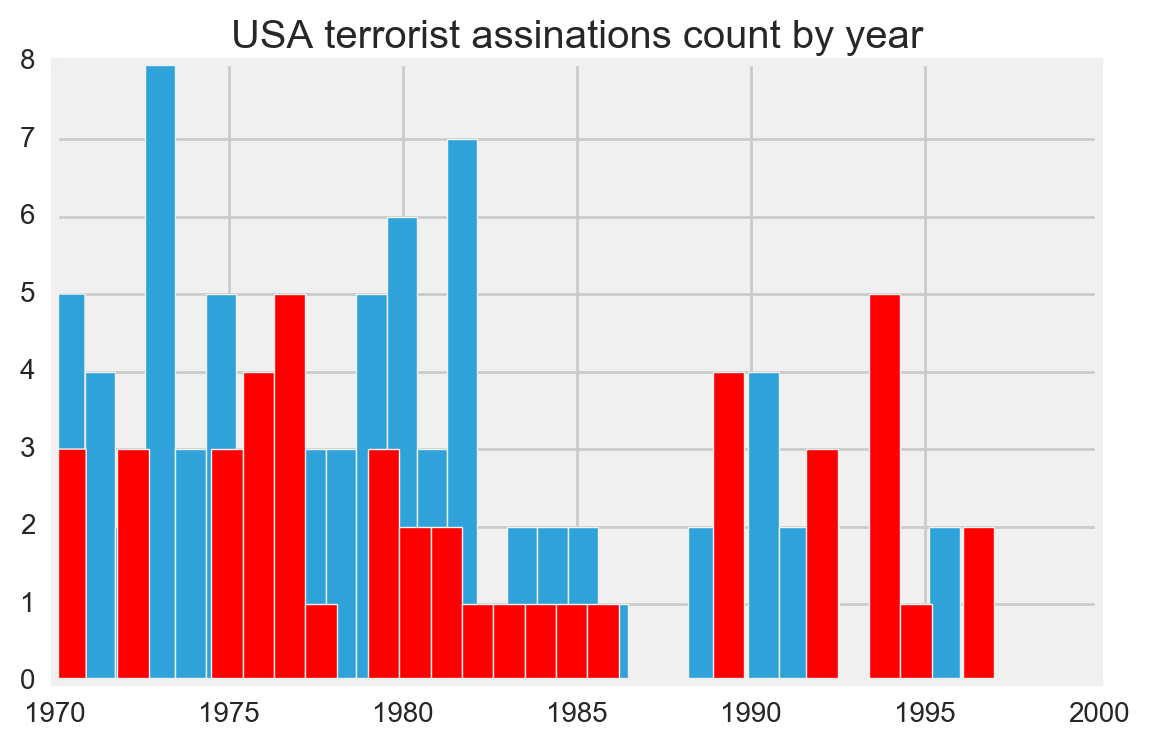

In [123]:
plt.hist(df[(df.attacktype1 ==1) & (df.country == 217) & (df.success==1)]['iyear'],bins = 30)
plt.hist(df[(df.attacktype1 ==1) & (df.country == 217) & (df.success==0)]['iyear'],color='r',bins = 30)
plt.title("USA terrorist assinations count by year")
plt.show

<function matplotlib.pyplot.show>

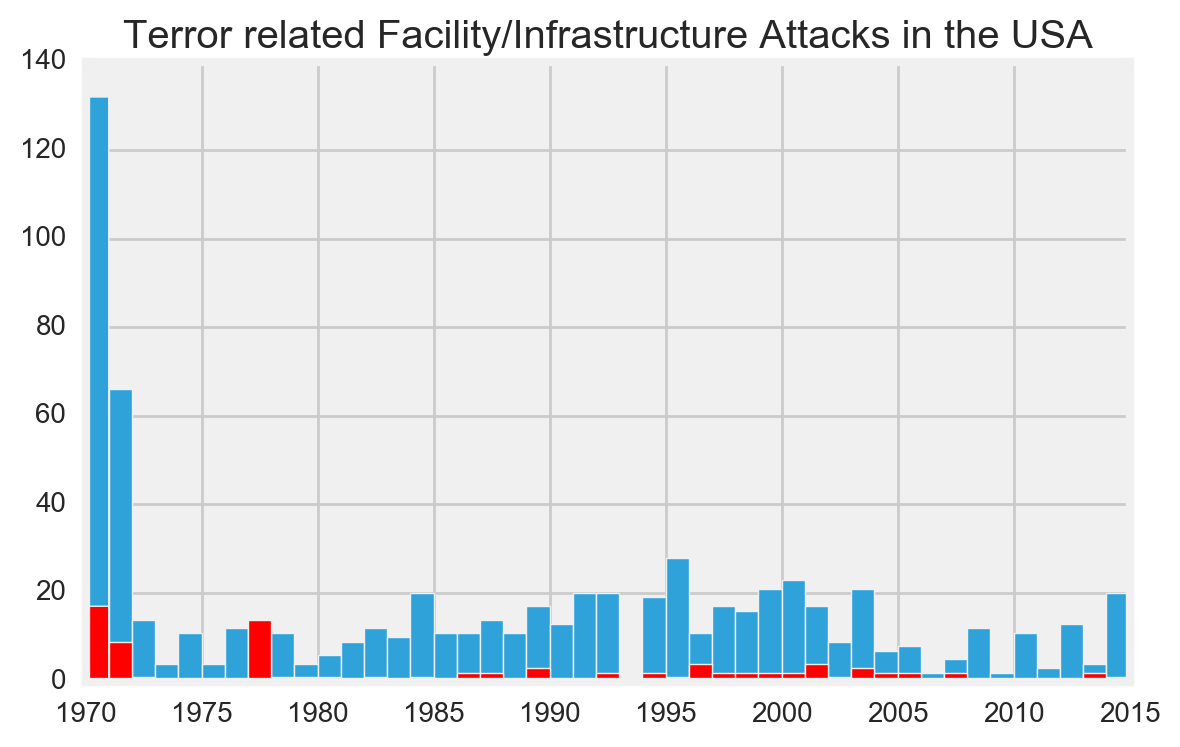

In [122]:
plt.hist(df[(df.attacktype1 ==7) & (df.country == 217)& (df.success==1)]['iyear'],bins = 45)
plt.hist(df[(df.attacktype1 ==7) & (df.country == 217)& (df.success==0)]['iyear'],color ='r',bins = 45)
plt.title("Terror related Facility/Infrastructure Attacks in the USA")
plt.show

<function matplotlib.pyplot.show>

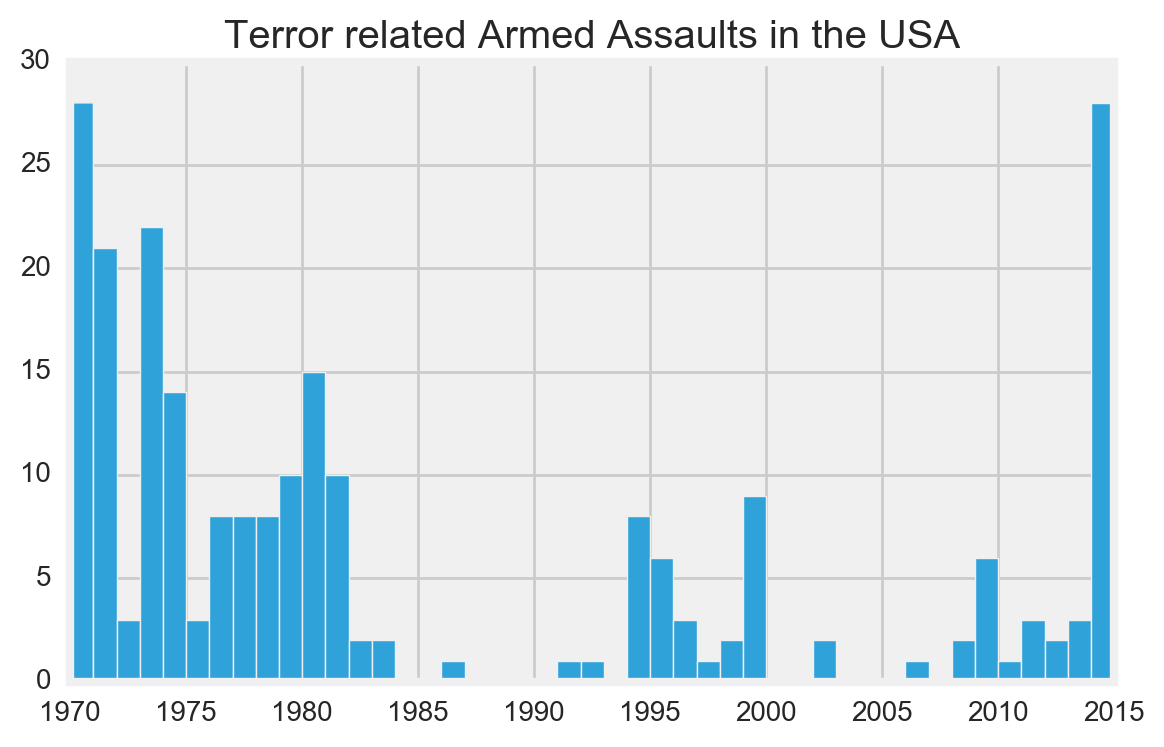

In [36]:
plt.hist(df[(df.attacktype1 ==2) & (df.country == 217)]['iyear'],bins = 45)
plt.title("Terror related Armed Assaults in the USA")
plt.show

In [ ]:
plt.hist(df[(df.attacktype1 ==6) & (df.country == 217)]['iyear'],bins = 45)

<function matplotlib.pyplot.show>

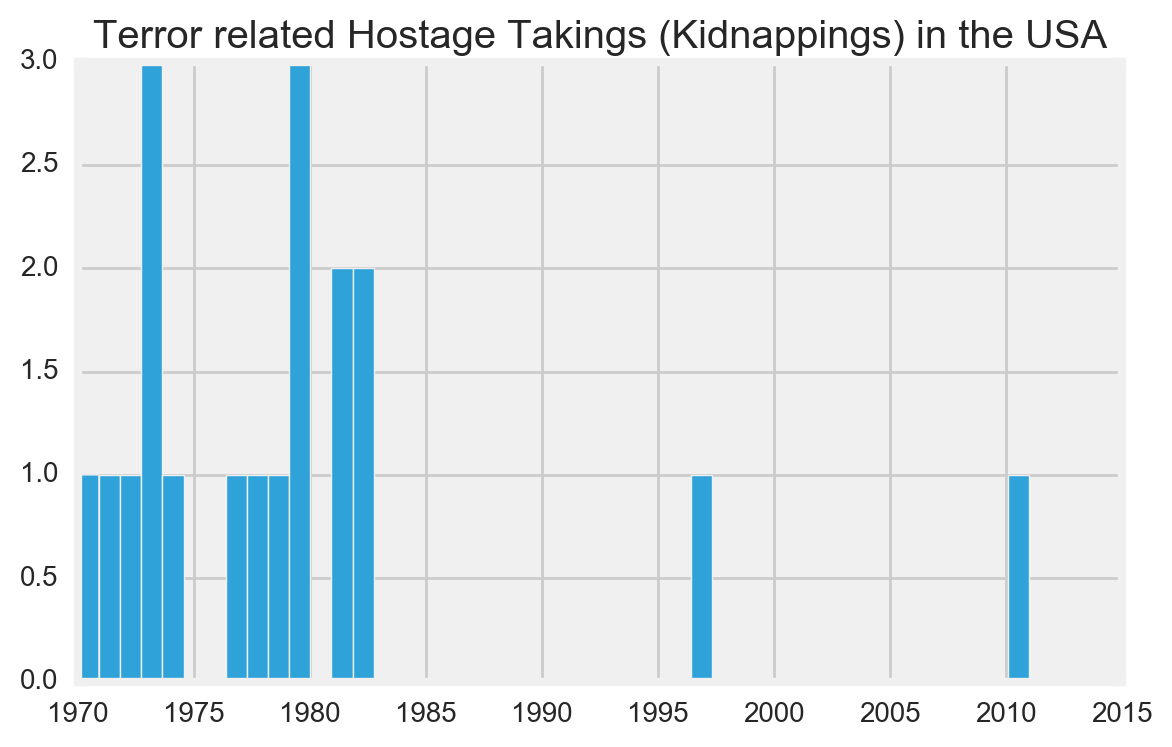

In [37]:
plt.hist(df[(df.attacktype1 ==6) & (df.country == 217)]['iyear'],bins = 45)
plt.title("Terror related Hostage Takings (Kidnappings) in the USA")
plt.show

In [85]:
df[(df.attacktype1 ==7) & (df.country == 217)][['iyear','propvalue']].head()

,iyear,propvalue
8,1970,60000.0
9,1970,NaN
11,1970,305.0
13,1970,NaN
14,1970,2000000.0


In [57]:
#df_year_propvalue = df[(df.attacktype1 ==7) & (df.country == 217)]

In [88]:
#df_year_propvalue

In [66]:
#df_year_propvalue['propvalue'].groupby(df_year_propvalue['iyear']).sum()

In [112]:
df['nkillus'].sum()

5195.0

In [84]:
year = set(df['iyear'])
len(year)

#plt.plot(df['nkillus'].groupby(df['iyear']).sum(),year)
#plt.show

45

In [315]:
#df['nkillus']

In [331]:
Mean_USA_deaths = df['nkillus'].sum()/len(year)
Mean_USA_deaths

115.44444444444444

In [332]:
mean_no911 = (df['nkillus'].sum()- 2910) /(len(year))
mean_no911

50.77777777777778

In [324]:
#Q1_2015_dict = Q1_2015.groupby('store_num').sales.sum().to_dict()
#plt.bar(myDictionary.keys(), myDictionary.values(), width, color='g')


Year_US_death_dict = df['nkillus'].groupby(df['iyear']).sum().to_dict()

Year_US_death_dict[1988]

201.0

<function matplotlib.pyplot.show>

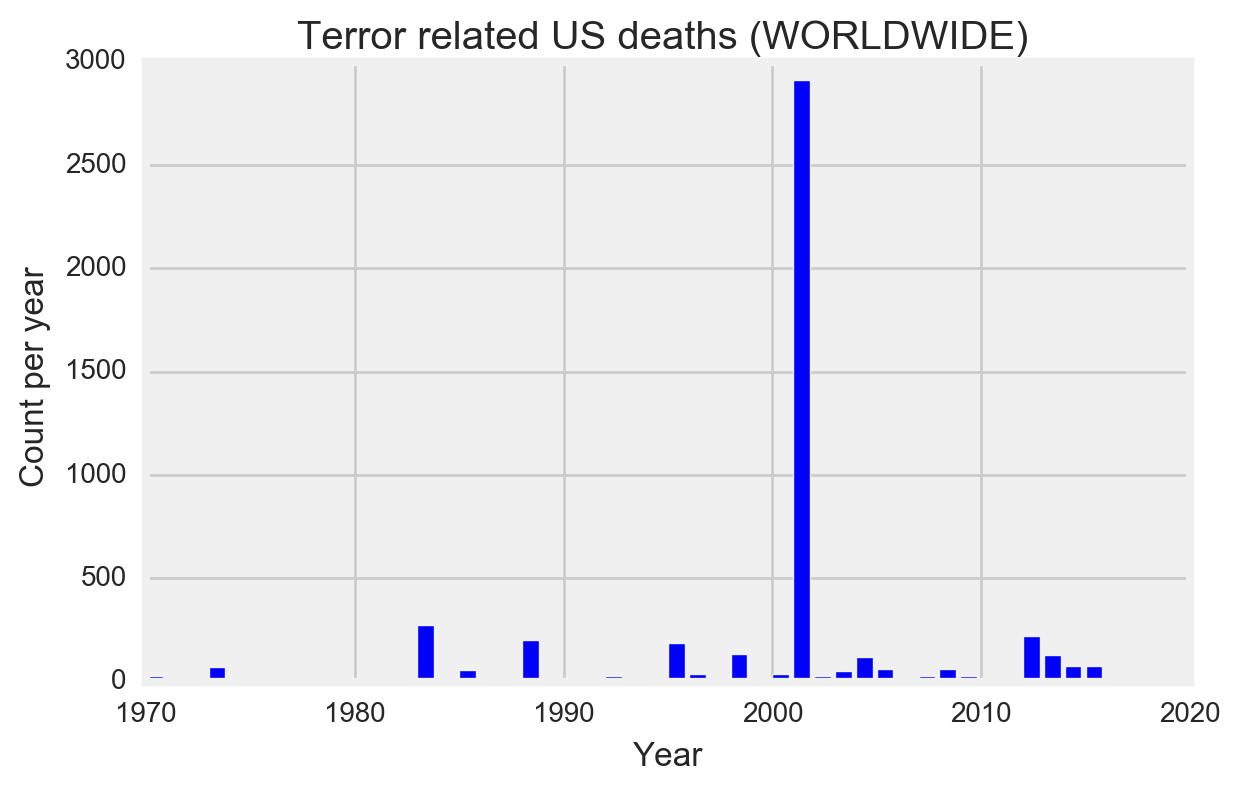

In [343]:

Year_US_death_dict[2001]=2910
plt.bar(Year_US_death_dict.keys(), Year_US_death_dict.values(), color='b')
plt.title("Terror related US deaths (WORLDWIDE) ")
plt.xlabel("Year")
plt.ylabel("Count per year ")
plt.savefig('World Wide with 911.jpg')
plt.show

In [109]:
Year_US_death_dict[2001]

2910.0

In [132]:
#fig = plt.figure(figsize=(7,5))
#ax = fig.gca()
#ax = sns.bar(Year_US_death_dict.keys(),Year_US_death_dict.values(), bins=45, ax=ax, kde=False)
#ax.axvline(mean_delay, lw=3, ls='dashed', color='black')
#plt.show()

In [316]:
Year_US_death_dict[2001]

0

In [319]:
Year_US_death_dict[1995]

188.0

In [326]:
#pd.DataFrame({'date' : dict_dates.keys() , 'date_value' : dict_dates.values() })
# with 9-11 data
US_deaths_per_year=pd.DataFrame({'year' : Year_US_death_dict.keys(), 'deaths':Year_US_death_dict.values()})
US_deaths_per_year.head()

,deaths,year
0,28.0,1970
1,15.0,1971
2,12.0,1972
3,73.0,1973
4,17.0,1974


In [327]:
#  with 9-11 data
US_deaths_per_year.mean()

deaths     115.444444
year      1992.488889
dtype: float64

In [366]:
# with 9-11 data  
US_deaths_per_year.std()

deaths    430.668379
year       13.574077
dtype: float64

In [329]:
# take 9-11 data out 
Year_US_death_dict[2001]=0
US_deaths_per_year_no911=pd.DataFrame({'year' : Year_US_death_dict.keys(), 'deaths':Year_US_death_dict.values()})
US_deaths_per_year_no911.head()

,deaths,year
0,28.0,1970
1,15.0,1971
2,12.0,1972
3,73.0,1973
4,17.0,1974


In [333]:
#  world wide without 911
US_deaths_per_year_no911.describe()

,deaths,year
count,45.000000,45.000000
mean,50.777778,1992.488889
std,63.338517,13.574077
min,0.000000,1970.000000
25%,15.000000,1981.000000
50%,23.000000,1992.000000
75%,59.000000,2004.000000
max,276.000000,2015.000000


In [363]:
US_deaths_per_year_no911.head()

,deaths,year
0,28.0,1970
1,15.0,1971
2,12.0,1972
3,73.0,1973
4,17.0,1974


<function matplotlib.pyplot.show>

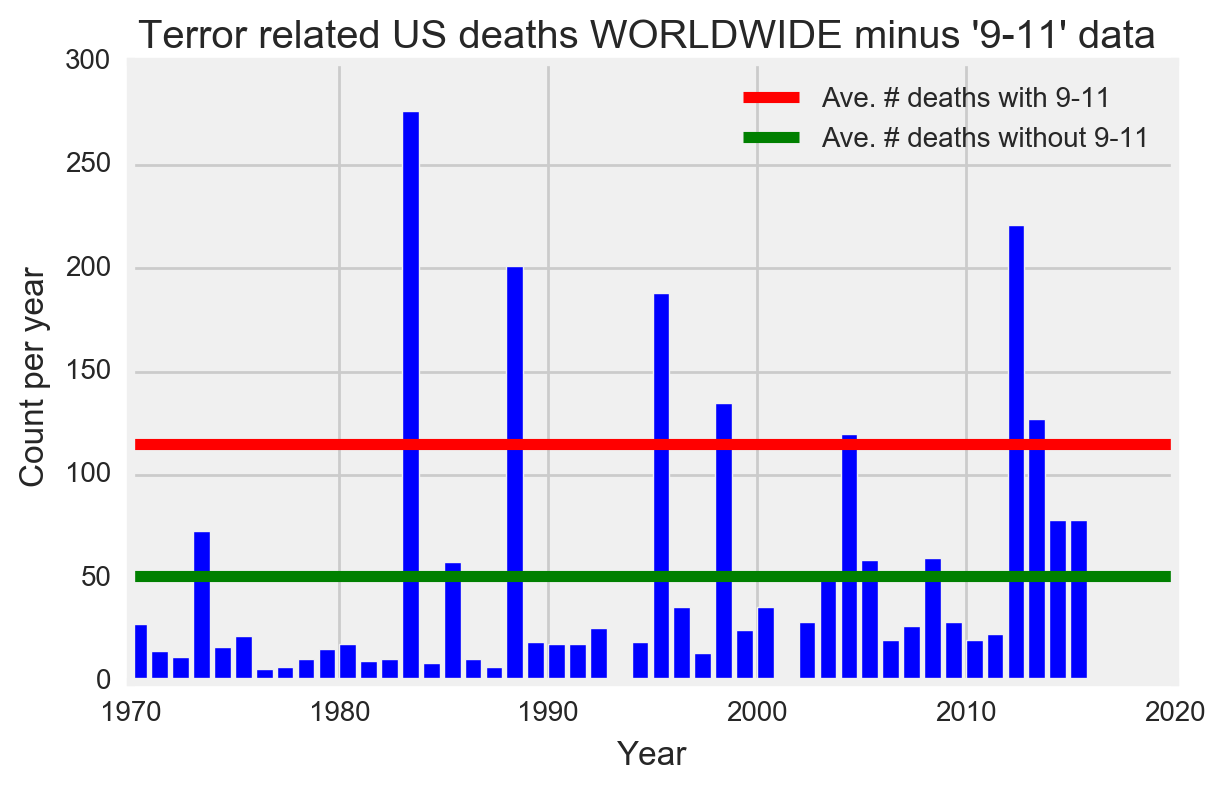

In [341]:
import pylab 

plt.bar(US_deaths_per_year_no911['year'], US_deaths_per_year_no911['deaths'], color='b')
plt.plot((1970, 2020), (115, 115), 'k-', color = "r", label= 'Ave. # deaths with 9-11')
plt.plot((1970, 2020), (51, 51), 'k-', color = "g", label= 'Ave. # deaths without 9-11')
plt.title("Terror related US deaths (WORLDWIDE) minus '9-11' data ")
pylab.legend(loc='upper right')
plt.xlabel("Year")
plt.ylabel("Count per year ")
plt.savefig('World Wide - 911.jpg')
plt.show

<function matplotlib.pyplot.show>

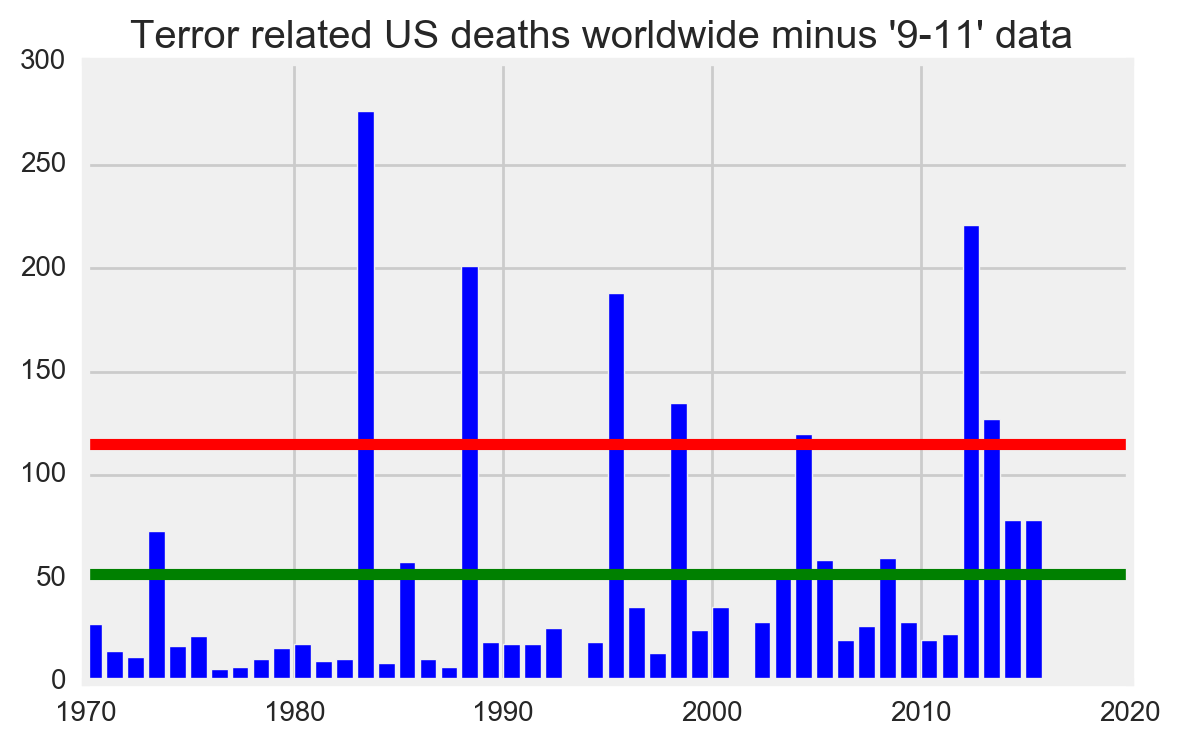

In [129]:

Year_US_death_dict[2001]=0
plt.bar(Year_US_death_dict.keys(), Year_US_death_dict.values(), color='b')
plt.plot((1970, 2020), (51, 51), 'k-', color = "g")
plt.plot((1970, 2020), (115, 115), 'k-', color = "r")
plt.title("Terror related US deaths worldwide minus '9-11' data ")
plt.show

<function matplotlib.pyplot.show>

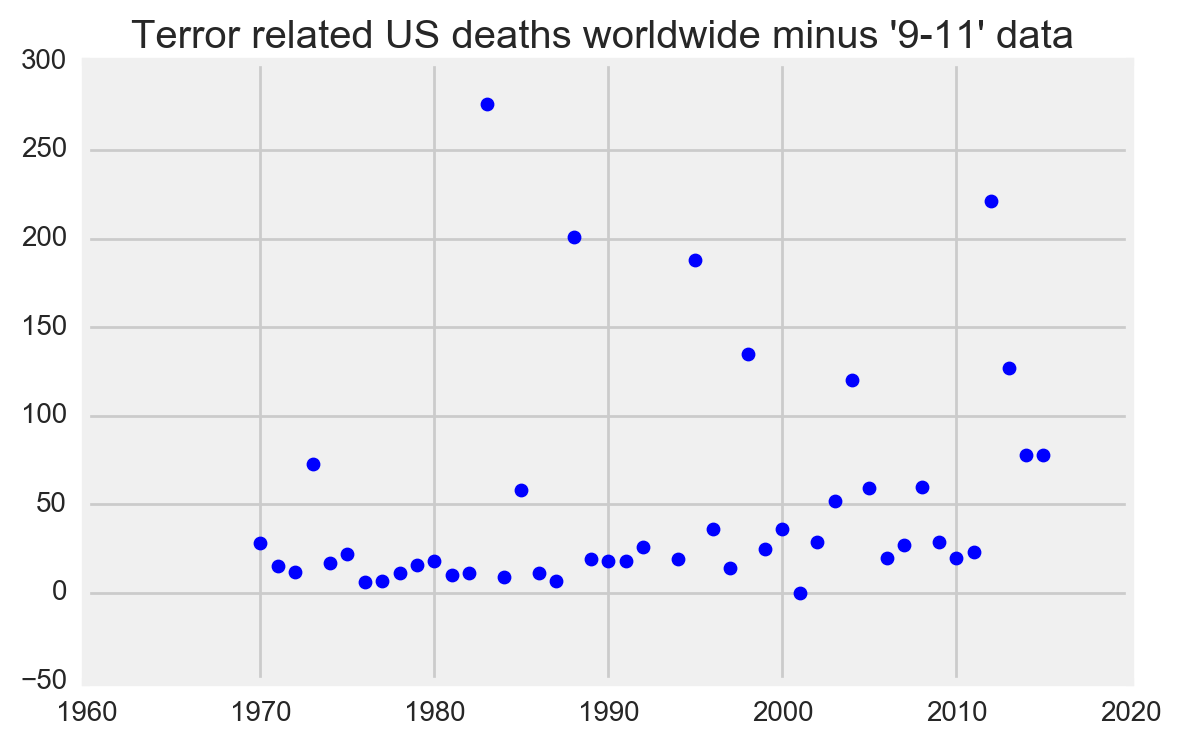

In [206]:
Year_US_death_dict[2001]=0
plt.scatter(Year_US_death_dict.keys(), Year_US_death_dict.values(), color='b')
#plt.plot((1970, 2020), (51, 51), 'k-', color = "g")
#plt.plot((1970, 2020), (115, 115), 'k-', color = "r")
plt.title("Terror related US deaths worldwide minus '9-11' data ")
plt.show

<function matplotlib.pyplot.show>

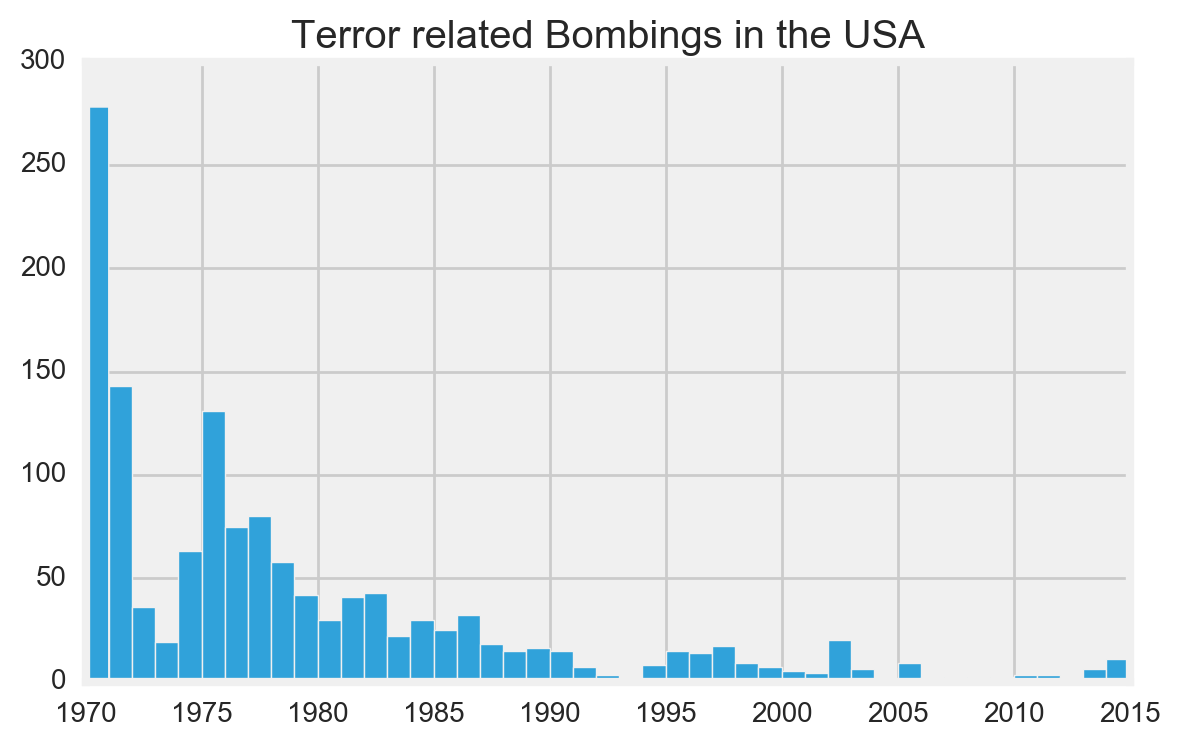

In [195]:
plt.hist(df[(df.attacktype1 ==3) & (df.country == 217)]['iyear'],bins = 45)
plt.title("Terror related Bombings in the USA")
plt.show

<function matplotlib.pyplot.show>

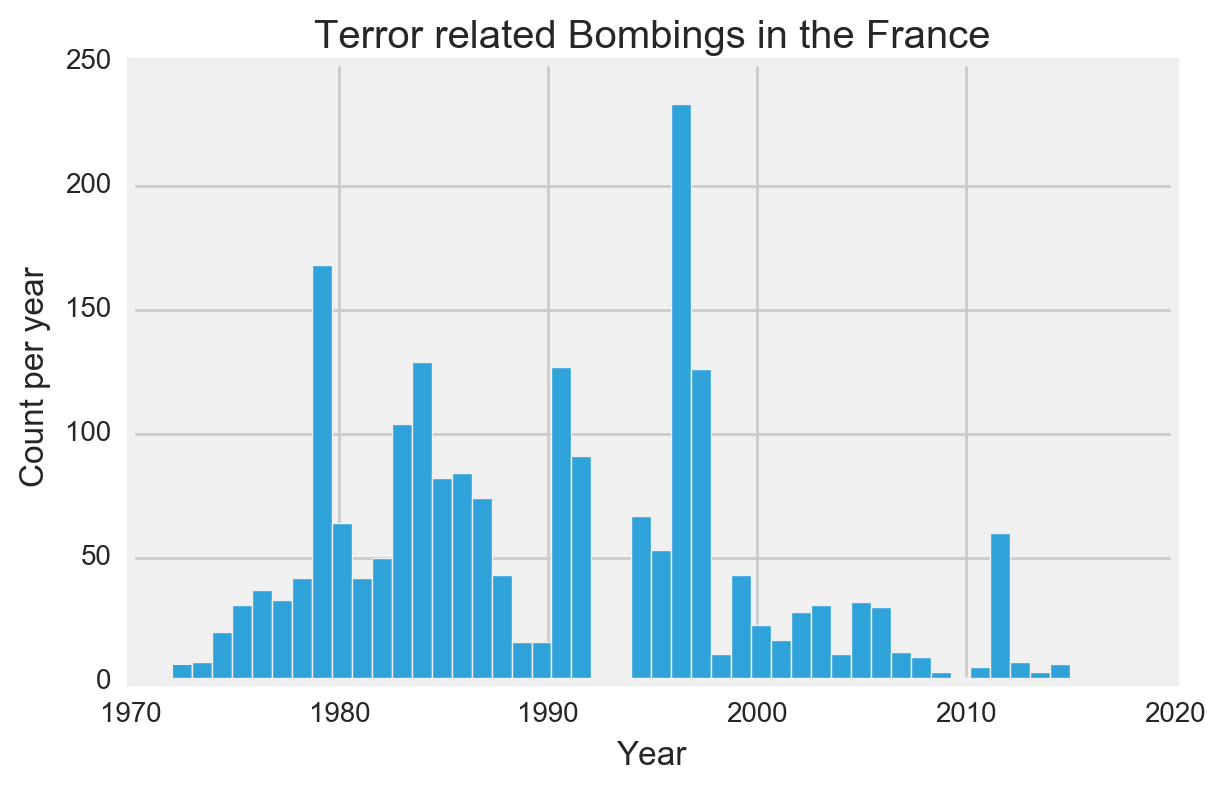

In [344]:
plt.hist(df[(df.attacktype1 ==3) & (df.country == 69)]['iyear'],bins = 45)
plt.title("Terror related Bombings in the France")
plt.xlabel("Year")
plt.ylabel("Count per year ")
plt.savefig('TRB France .jpg')
plt.show

<function matplotlib.pyplot.show>

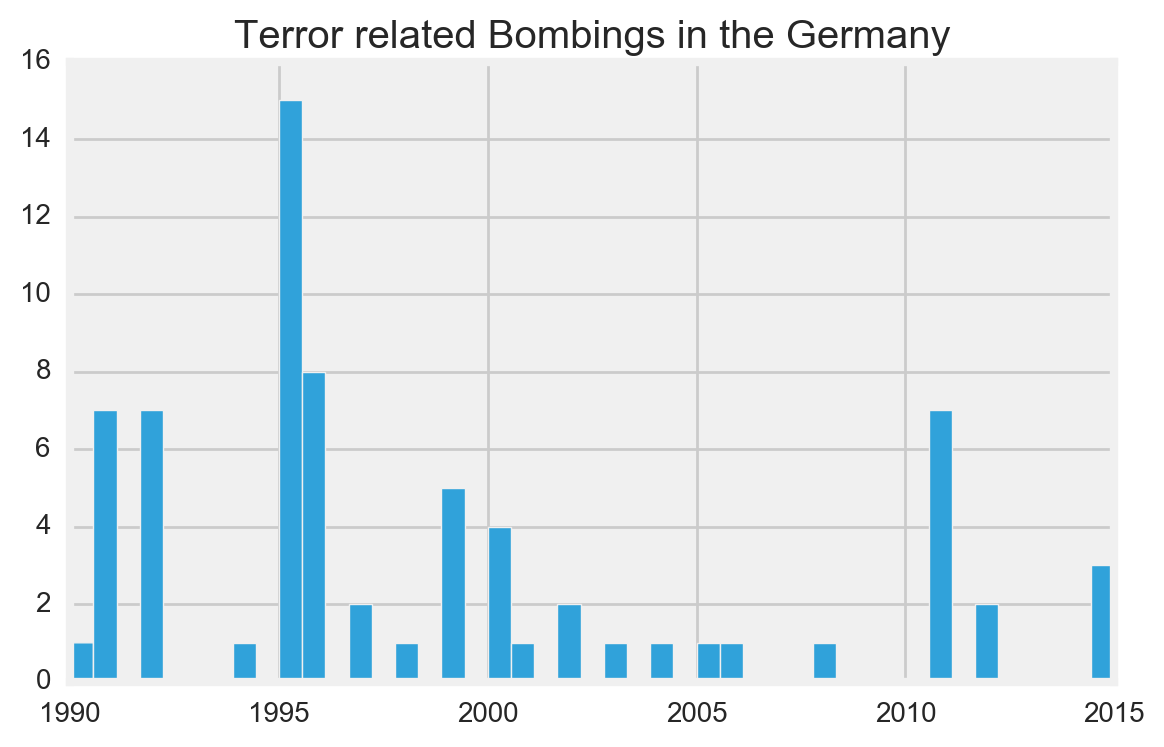

In [200]:
plt.hist(df[(df.attacktype1 ==3) & (df.country == 75)]['iyear'],bins = 45)
plt.title("Terror related Bombings in the Germany")
plt.show

<function matplotlib.pyplot.show>

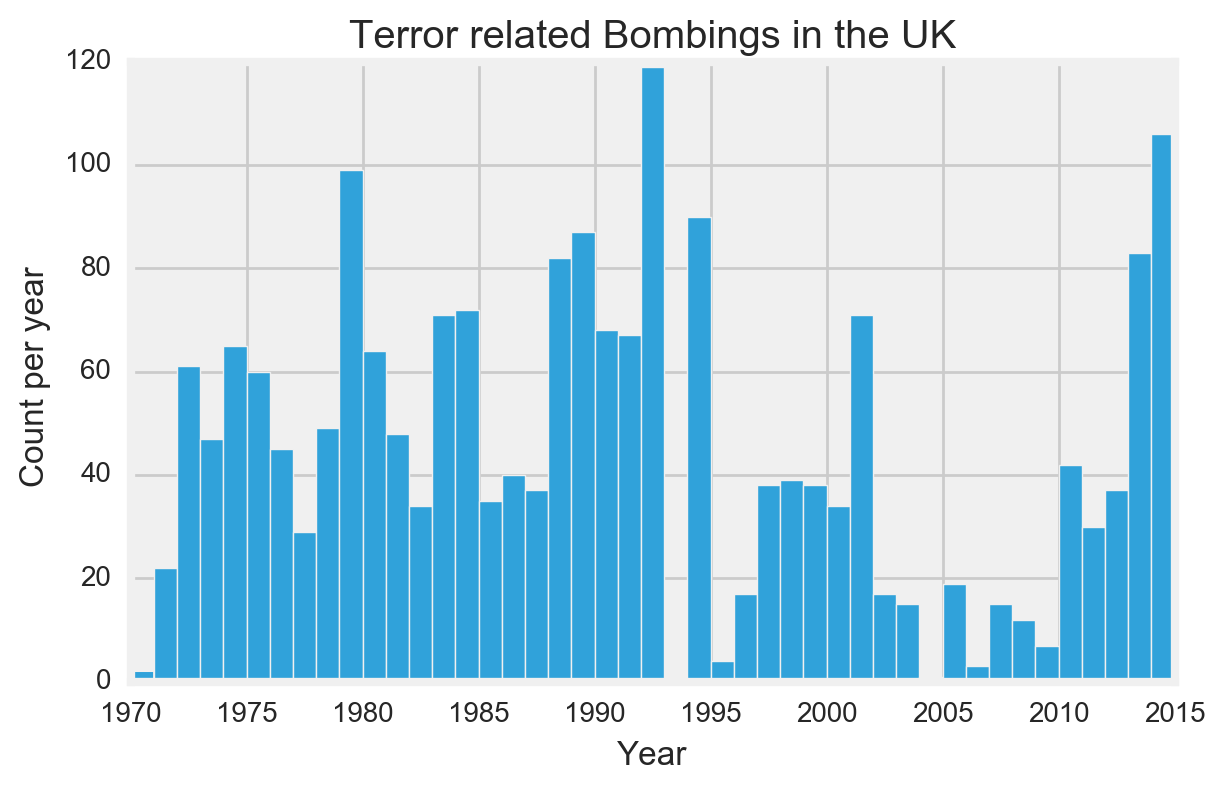

In [345]:
plt.hist(df[(df.attacktype1 ==3) & (df.country == 603)]['iyear'],bins = 45)
plt.title("Terror related Bombings in the UK")
plt.xlabel("Year")
plt.ylabel("Count per year ")
plt.savefig('TRB UK.jpg')
plt.show

In [222]:
# data frame for the above plot.  
df[(df.attacktype1 ==3) & (df.country == 603)]

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
458,197008110001,1970,8,11,NaN,0,NaN,603,United Kingdom,8,...,NaN,NaN,NaN,NaN,CAIN,0,0,1,1,NaN
497,197009040003,1970,9,4,NaN,0,NaN,603,United Kingdom,8,...,NaN,NaN,NaN,NaN,CAIN,0,0,1,1,NaN
706,197102090001,1971,2,9,NaN,0,NaN,603,United Kingdom,8,...,NaN,NaN,NaN,NaN,CAIN,0,0,1,1,NaN
897,197105250002,1971,5,25,NaN,0,NaN,603,United Kingdom,8,...,NaN,NaN,NaN,NaN,CAIN,0,0,1,1,NaN
950,197108090002,1971,8,9,NaN,0,NaN,603,United Kingdom,8,...,NaN,NaN,NaN,NaN,CAIN,0,0,1,1,NaN
983,197108250002,1971,8,25,NaN,0,NaN,603,United Kingdom,8,...,NaN,NaN,NaN,NaN,CAIN,0,0,1,1,NaN
1003,197109040001,1971,9,4,NaN,0,NaN,603,United Kingdom,8,...,NaN,NaN,NaN,NaN,CAIN,0,0,1,1,NaN
1007,197109090002,1971,9,9,NaN,0,NaN,603,United Kingdom,8,...,NaN,NaN,NaN,NaN,CAIN,0,0,1,1,NaN
1008,197109130001,1971,9,13,NaN,0,NaN,603,United Kingdom,8,...,NaN,NaN,NaN,NaN,CAIN,-9,-9,1,1,NaN
1009,197109130002,1971,9,13,NaN,0,NaN,603,United Kingdom,8,...,NaN,NaN,NaN,NaN,CAIN,-9,-9,1,1,NaN


In [224]:
df[(df.attacktype1 ==3) & (df.country == 603)]['iyear'].values

array([1970, 1970, 1971, ..., 2015, 2015, 2015])

<function matplotlib.pyplot.show>

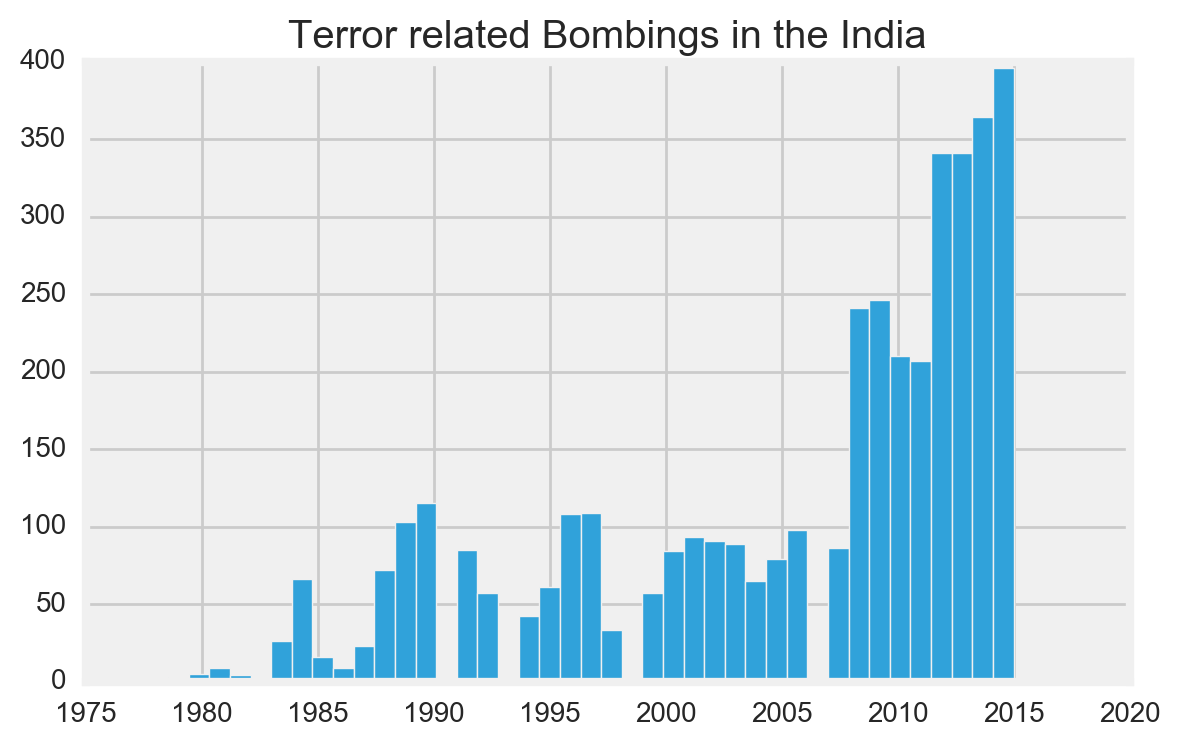

In [203]:
plt.hist(df[(df.attacktype1 ==3) & (df.country == 92)]['iyear'],bins = 45)
plt.title("Terror related Bombings in the India")
plt.show

<function matplotlib.pyplot.show>

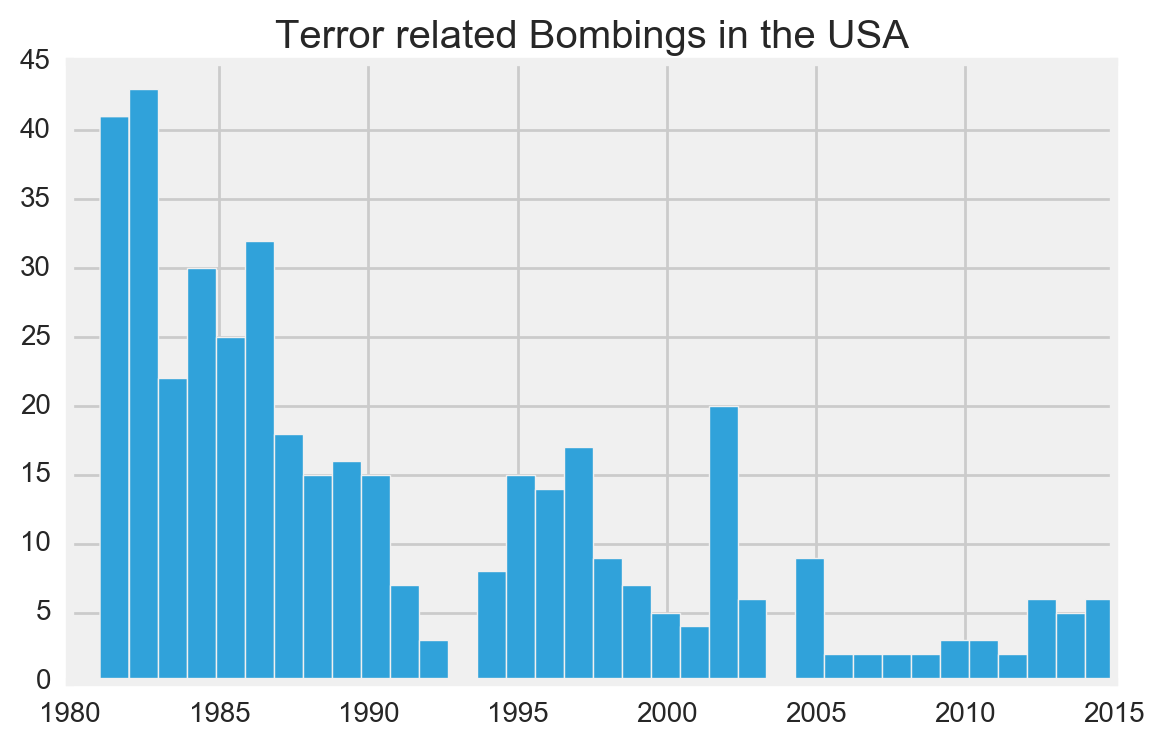

In [205]:
plt.hist(df[(df.attacktype1 ==3) & (df.country == 217)&(df.iyear>1980)]['iyear'],bins = 35)
plt.title("Terror related Bombings in the USA")
plt.show

<function matplotlib.pyplot.show>

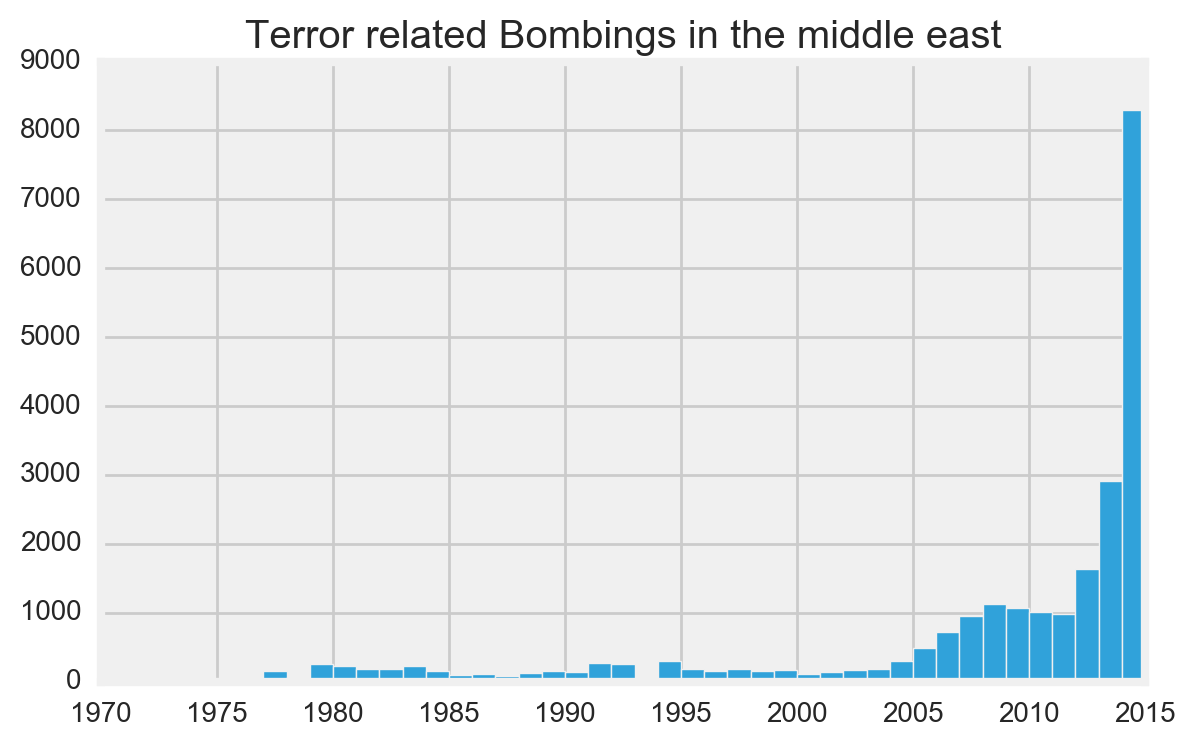

In [211]:
# Do regions 
plt.hist(df[(df.attacktype1 ==3) & (df.region == 10)]['iyear'],bins = 45)
plt.title("Terror related Bombings in the middle east")
plt.show

<function matplotlib.pyplot.show>

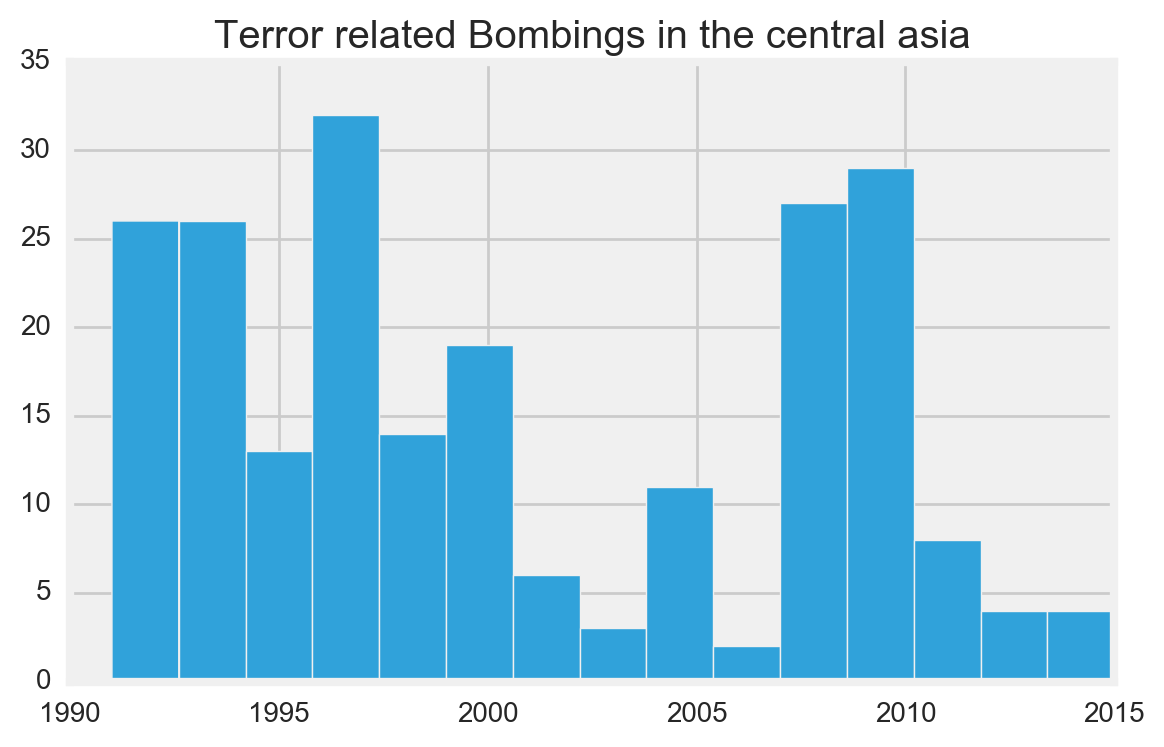

In [217]:
# Do regions 
plt.hist(df[(df.attacktype1 ==3) & (df.region == 7)]['iyear'],bins = 15)
plt.title("Terror related Bombings in the central asia")
plt.show

<function matplotlib.pyplot.show>

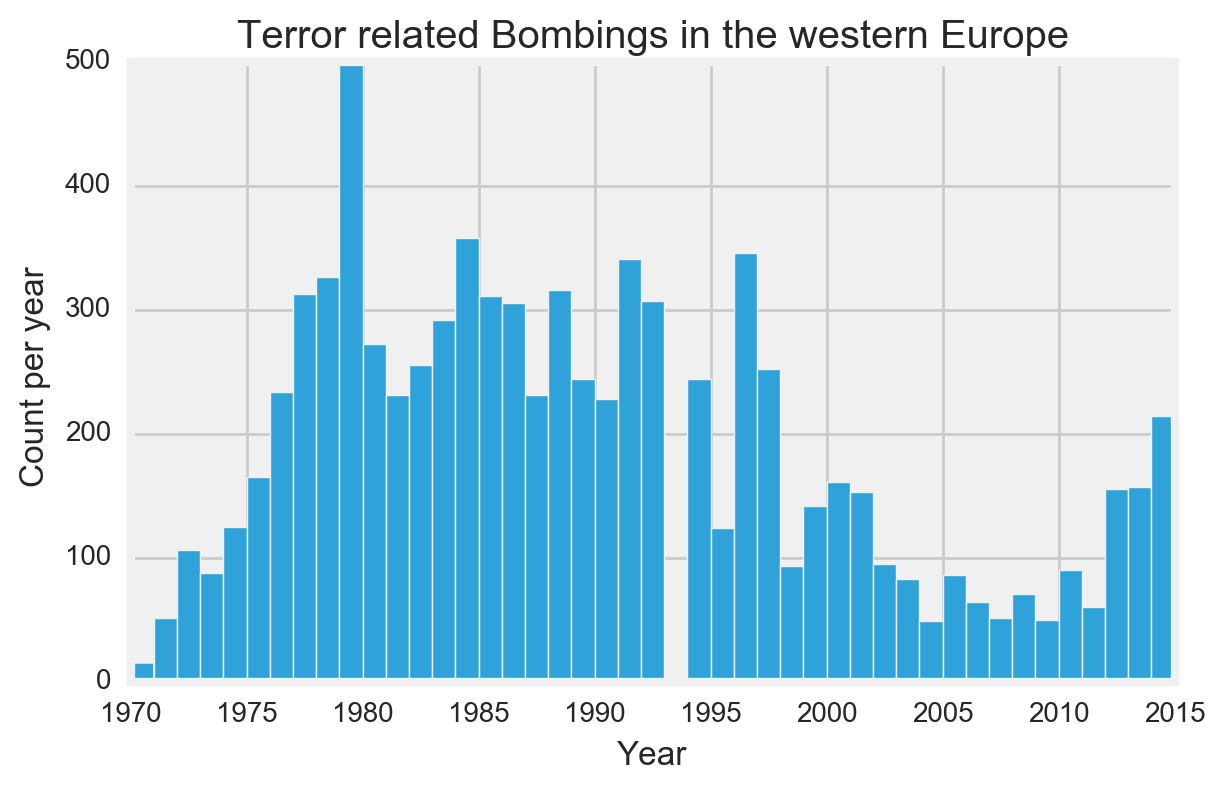

In [365]:
# Do regions 
plt.hist(df[(df.attacktype1 ==3) & (df.region == 8)]['iyear'],bins = 45)
plt.title("Terror related Bombings in the western Europe")
plt.xlabel("Year")
plt.ylabel("Count per year ")
plt.savefig('TRB Western EU.jpg')
plt.show

In [294]:
# find the standard deviation and mean of Western Europe.  

df[(df.attacktype1 ==3) & (df.region == 8)]['iyear'].describe()

count    8354.000000
mean     1989.289562
std        11.073909
min      1970.000000
25%      1980.000000
50%      1987.000000
75%      1996.000000
max      2015.000000
Name: iyear, dtype: float64

In [373]:
print df[(df.attacktype1 ==3)]['iyear'].value_counts().describe()

count      45.000000
mean     1688.066667
std      1856.550680
min       149.000000
25%       655.000000
50%      1125.000000
75%      1775.000000
max      8759.000000
Name: iyear, dtype: float64


In [384]:
print df[(df.attacktype1 ==3)]['iyear'].value_counts().mean()

1688.06666667


In [383]:
print df[(df.attacktype1 ==3) & (df.iyear <1995)]['iyear'].value_counts()

1991    1988
1989    1797
1984    1775
1992    1738
1990    1731
1988    1650
1986    1506
1985    1482
1987    1476
1983    1246
1994    1153
1982    1125
1981    1082
1979    1057
1980     997
1978     644
1977     635
1976     419
1975     370
1970     333
1974     284
1971     238
1972     186
1973     149
Name: iyear, dtype: int64


Find the mean and standard deviation of terrorist related bombing in all of Western EU.  These values will be used to inform our priors. 

In [295]:
# following the procedure from the pymc.sam lab...
# mean_prior_mean = star.APM.mean()     mean_prior_mean -> EU_prior_mean  regional mean (west Eu)
# mean_prior_std = star.APM.std()       mean_prior_std -> EU_prior_std    regional std  (west EU)

#EU_prior_mean = df[(df.attacktype1 ==3) & (df.region == 8)]['iyear'].mean()
#EU_prior_std = df[(df.attacktype1 ==3) & (df.region == 8)]['iyear'].std()
EU_prior_mean = df[(df.attacktype1 ==3) & (df.region == 8)& (df.iyear <2000)]['iyear'].value_counts().mean()
EU_prior_std = df[(df.attacktype1 ==3) & (df.region == 8)& (df.iyear <2000)]['iyear'].value_counts().std()
print 'Western EU TRB mean =',EU_prior_mean, '  Western EU TRB st.dev. =',EU_prior_std

Western EU TRB mean = 235.0   Western EU TRB st.dev. = 108.543605458


In [268]:
print df[(df.attacktype1 ==3) & (df.region == 8)]['iyear'].value_counts().mean()

185.644444444


In [273]:
print df[(df.attacktype1 ==3) & (df.region == 8)]['iyear'].value_counts().std()

112.117259144


Data for France and the UK on the numbers of Terror Related Bombings (TRB) in each country.

In [301]:
# continue following the procedure from the pymc.sam lab 
# using France and UK instead of 19 and 26 year olds
# apm19 = star[star.Age == '19'].APM.values    apm19 -> France_data  French data for later
# apm26 = star[star.Age == '26'].APM.values    apm26 -> UK_data       UK data for later

#France_data = df[(df.attacktype1 ==3) & (df.country == 69)]['iyear'].values
#UK_data = df[(df.attacktype1 ==3) & (df.country == 603)]['iyear'].values
France_data = df[(df.attacktype1 ==3) & (df.country == 69)& (df.iyear >=2000)]['iyear'].value_counts().values
UK_data = df[(df.attacktype1 ==3) & (df.country == 603)& (df.iyear >=2000)]['iyear'].value_counts().values

In [272]:
df[(df.attacktype1 ==3) & (df.country == 69)]['iyear'].value_counts().values

array([233, 168, 129, 127, 126, 104,  91,  84,  82,  74,  67,  64,  60,
        53,  50,  43,  43,  42,  42,  37,  33,  32,  31,  31,  30,  28,
        23,  20,  17,  16,  16,  12,  11,  11,  10,   8,   8,   7,   7,
         6,   4,   4,   2])

In [275]:
df[(df.attacktype1 ==3) & (df.country == 603)]['iyear'].value_counts().values

array([119,  99,  90,  87,  83,  82,  72,  71,  71,  68,  67,  65,  64,
        61,  60,  55,  51,  49,  48,  47,  45,  42,  40,  39,  38,  38,
        37,  37,  35,  34,  34,  30,  29,  22,  19,  17,  17,  15,  15,
        12,   7,   4,   3,   2,   1])

Set up the distributions for the mean and standard deviation of the TRB for West. EU. 

In [304]:
# continue following the procedure from the pymc.sam lab
## model specifications in PyMC3 are wrapped in a with-statement
#  group19_mean = pm.Normal('APM_19yo_mean', mean_prior_mean, sd=mean_prior_std)
#  group26_mean = pm.Normal('APM_26yo_mean', mean_prior_mean, sd=mean_prior_std)

with pm.Model() as model:

    France_mean = pm.Normal('TRB_France_mean', EU_prior_mean, sd=EU_prior_std)
    UK_mean = pm.Normal('TRB_UK_mean', EU_prior_mean, sd=EU_prior_std)

In [305]:
# group19_std = pm.Uniform('APM_19yo_std', lower=std_prior_lower, upper=std_prior_upper)
# group26_std = pm.Uniform('APM_26yo_std', lower=std_prior_lower, upper=std_prior_upper)
#

std_prior_lower = 0.01
std_prior_upper = 100.0

with model:
    
    France_std = pm.Uniform('TRB_France_std', lower=std_prior_lower, upper=std_prior_upper)
    UK_std = pm.Uniform('TRB_UK_std', lower=std_prior_lower, upper=std_prior_upper)

In [306]:
#    group19 = pm.Normal('APM_19yo', mu=group19_mean, sd=group19_std, observed=apm19)
#    group26 = pm.Normal('APM_26yo', mu=group26_mean, sd=group26_std, observed=apm26)

with model:

    France = pm.Normal('TRB_French', mu=France_mean, sd=France_std, observed=France_data)
    UK = pm.Normal('TRB_UK', mu=UK_mean, sd=UK_std, observed=UK_data)

In [307]:
#     diff_of_means = pm.Deterministic('difference of means', group19_mean - group26_mean)
#    diff_of_stds = pm.Deterministic('difference of stds', group19_std - group26_std)
#    effect_size = pm.Deterministic('effect size',
#                                   diff_of_means / np.sqrt((group19_std**2 + group26_std**2) / 2))


with model:

    diff_of_means = pm.Deterministic('difference of means', France_mean - UK_mean)
    diff_of_stds = pm.Deterministic('difference of stds', France_std - UK_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((France_std**2 + UK_std**2) / 2))



In [308]:
with model:
    trace = pm.sample(25000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -229.29: 100%|██████████| 200000/200000 [00:18<00:00, 10756.66it/s]
Finished [100%]: Average ELBO = -226.32
100%|██████████| 25000/25000 [00:42<00:00, 582.07it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x134a99310>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x135359cd0>], dtype=object)

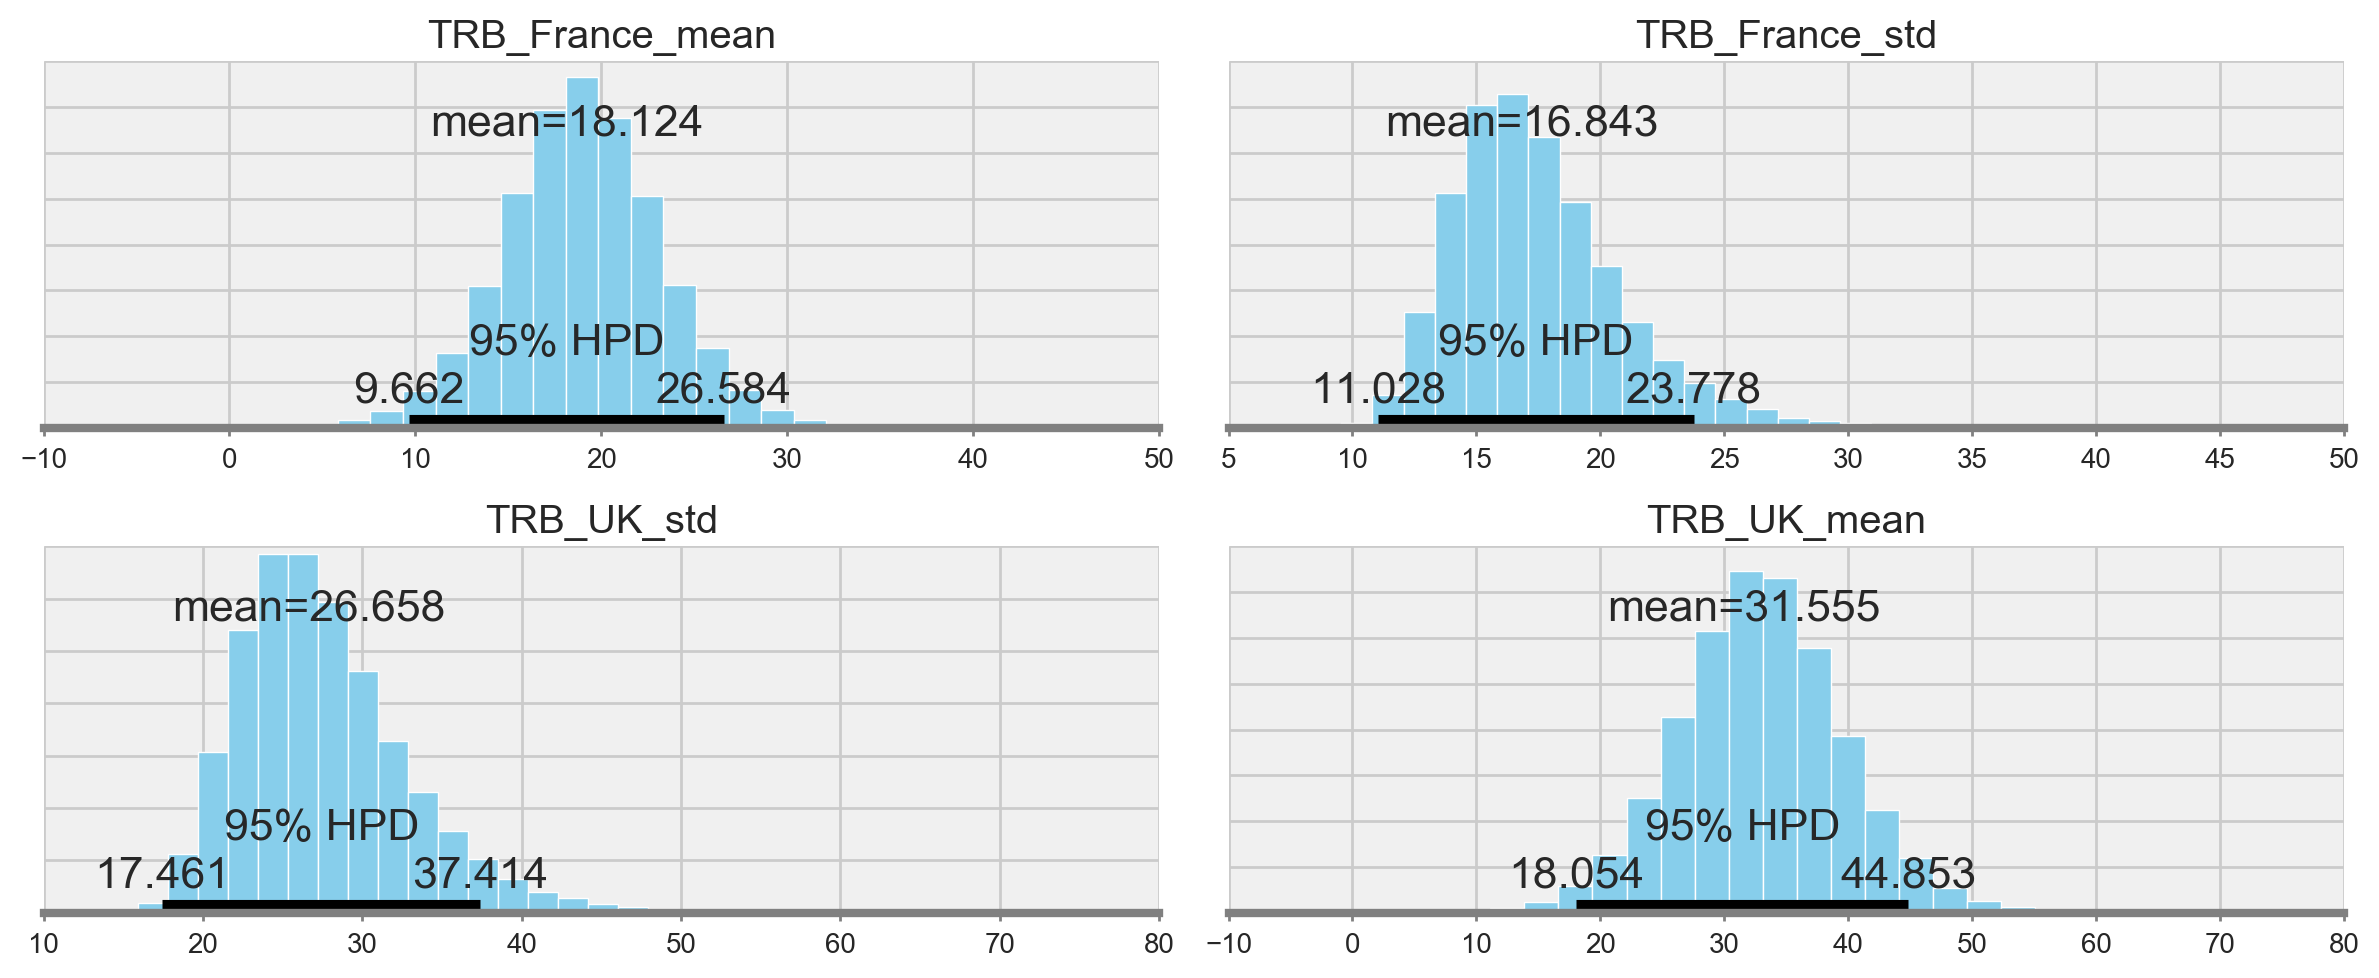

In [309]:
#pm.plot_posterior(trace[3000:],
#                  varnames=['APM_19yo_mean', 'APM_26yo_mean', 'APM_19yo_std', 'APM_26yo_std'],
#                  color='#87ceeb')

pm.plot_posterior(trace[3000:],
                  varnames=['TRB_France_mean', 'TRB_UK_mean', 'TRB_France_std', 'TRB_UK_std'],
                  color='#87ceeb')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1351cce50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1349ee190>], dtype=object)

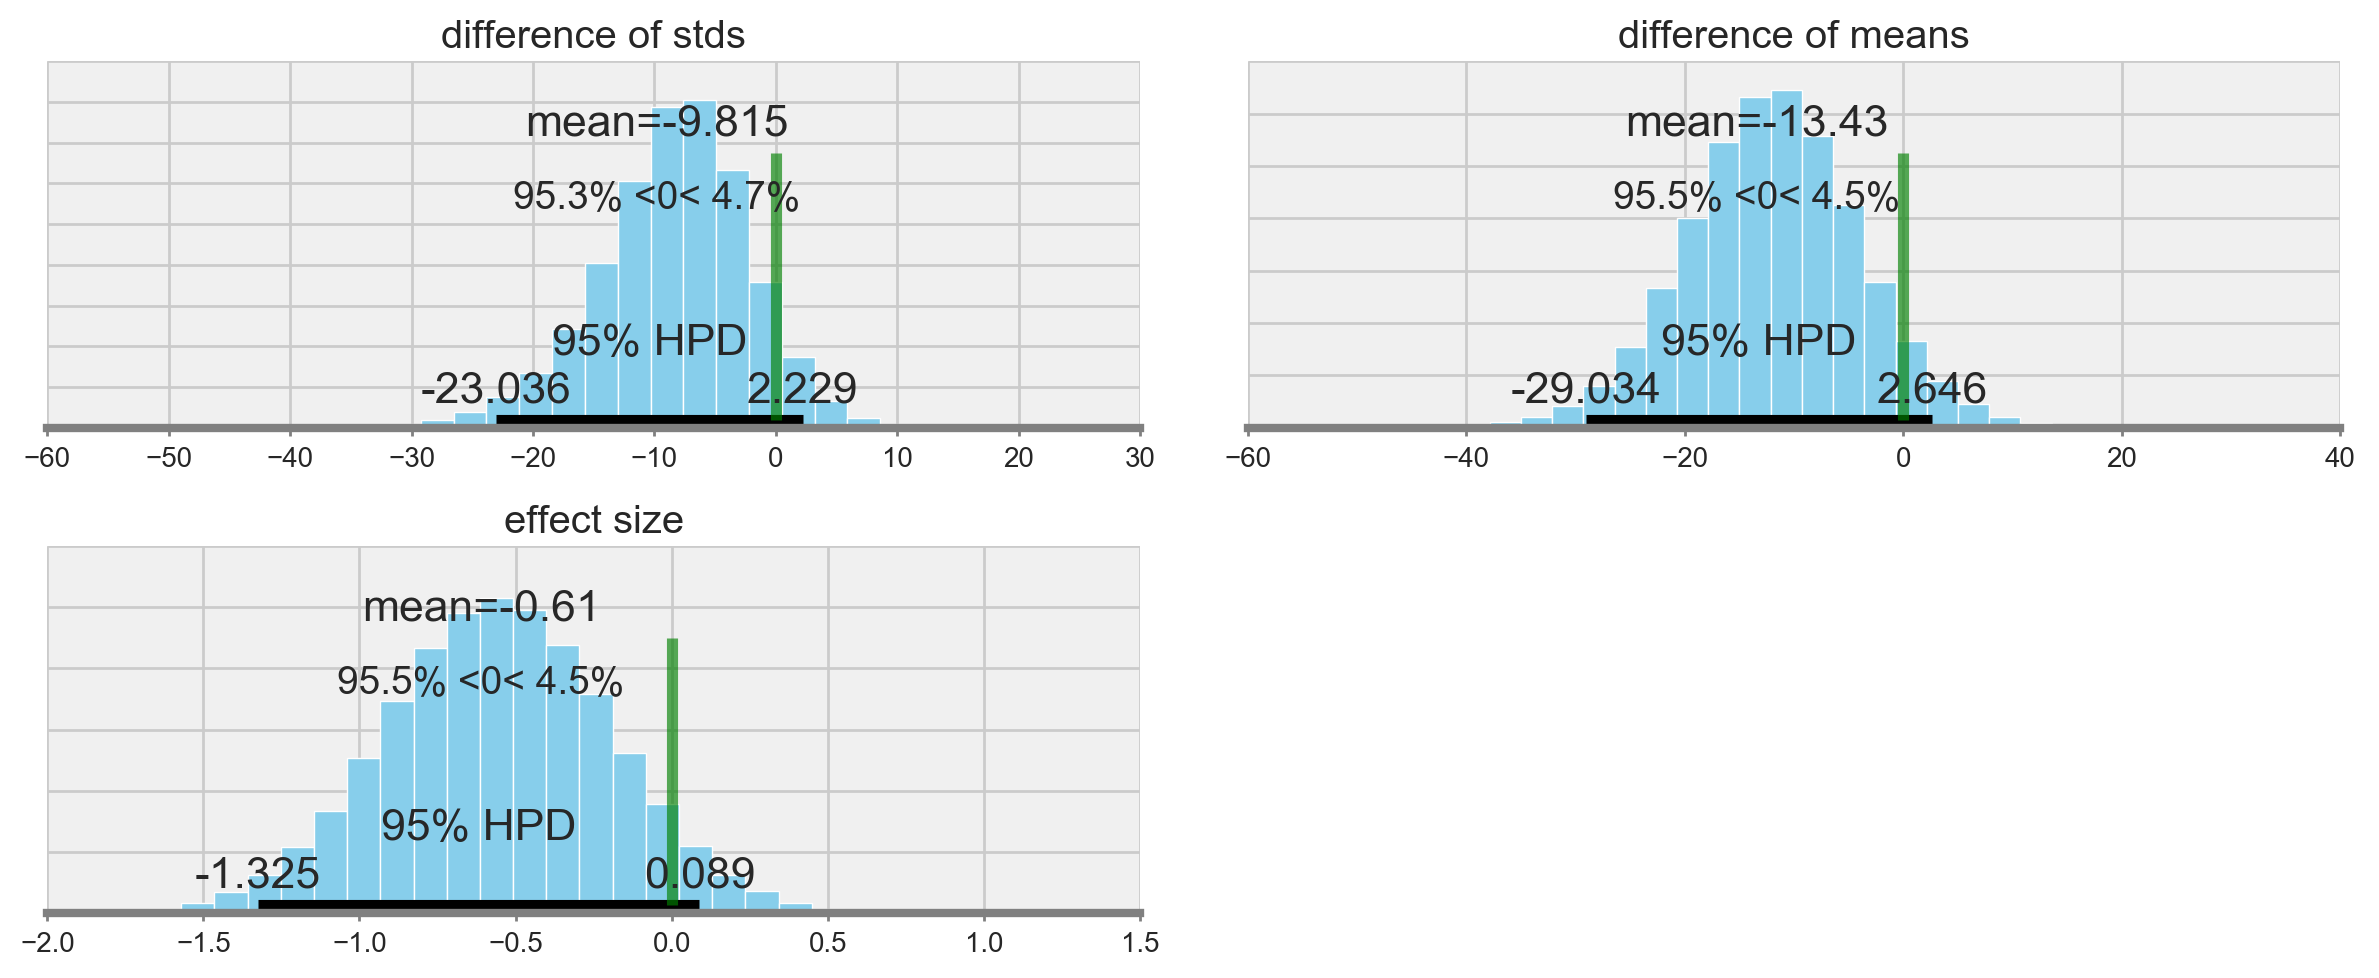

In [310]:
pm.plot_posterior(trace[3000:],
                  varnames=['difference of means', 'difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb')

In [264]:
pm.summary(trace[3000:],
           varnames=['difference of means', 'difference of stds', 'effect size'])


difference of means:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.538           0.345            0.001            [-1.221, 0.133]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -1.217         -0.772         -0.538         -0.306         0.138


difference of stds:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -3.202           0.245            0.001            [-3.675, -2.717]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -3.685         -3.366         -3.200         -3.036         -2.727


effect size:

  Mean             SD               MC Error         95% HPD

<function matplotlib.pyplot.show>

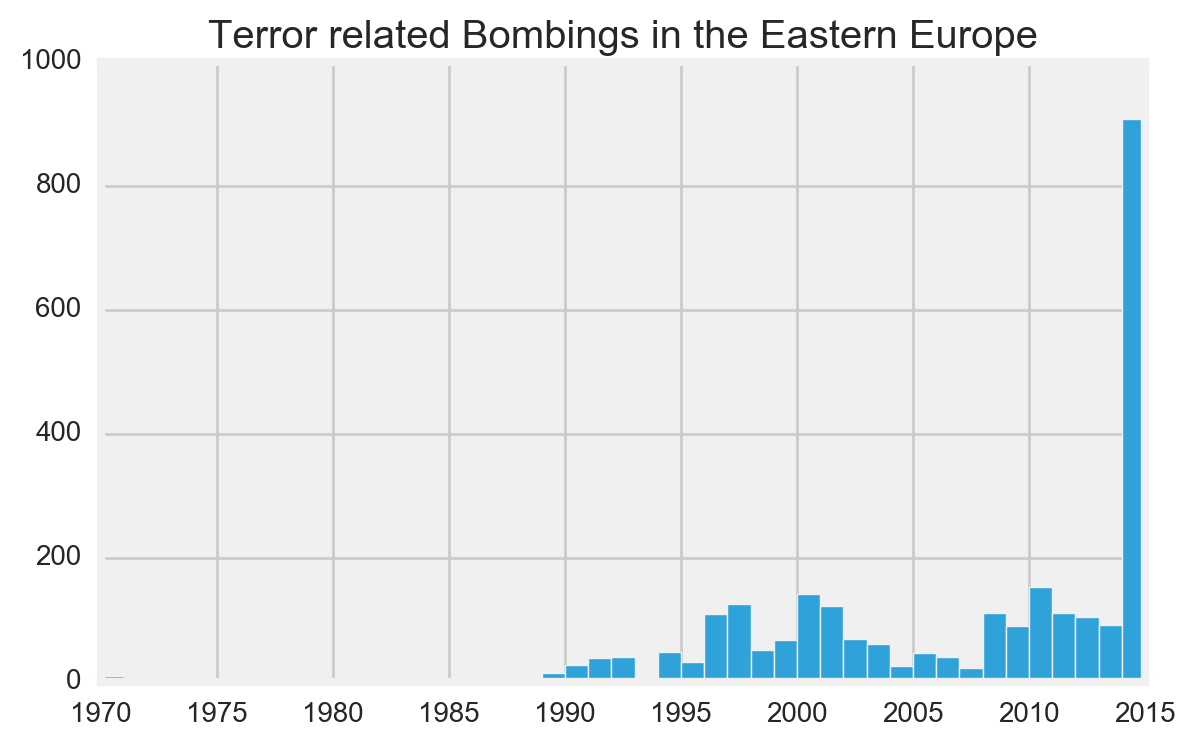

In [216]:
# Do regions 
plt.hist(df[(df.attacktype1 ==3) & (df.region == 9)]['iyear'],bins = 45)
plt.title("Terror related Bombings in the Eastern Europe")
plt.show

<function matplotlib.pyplot.show>

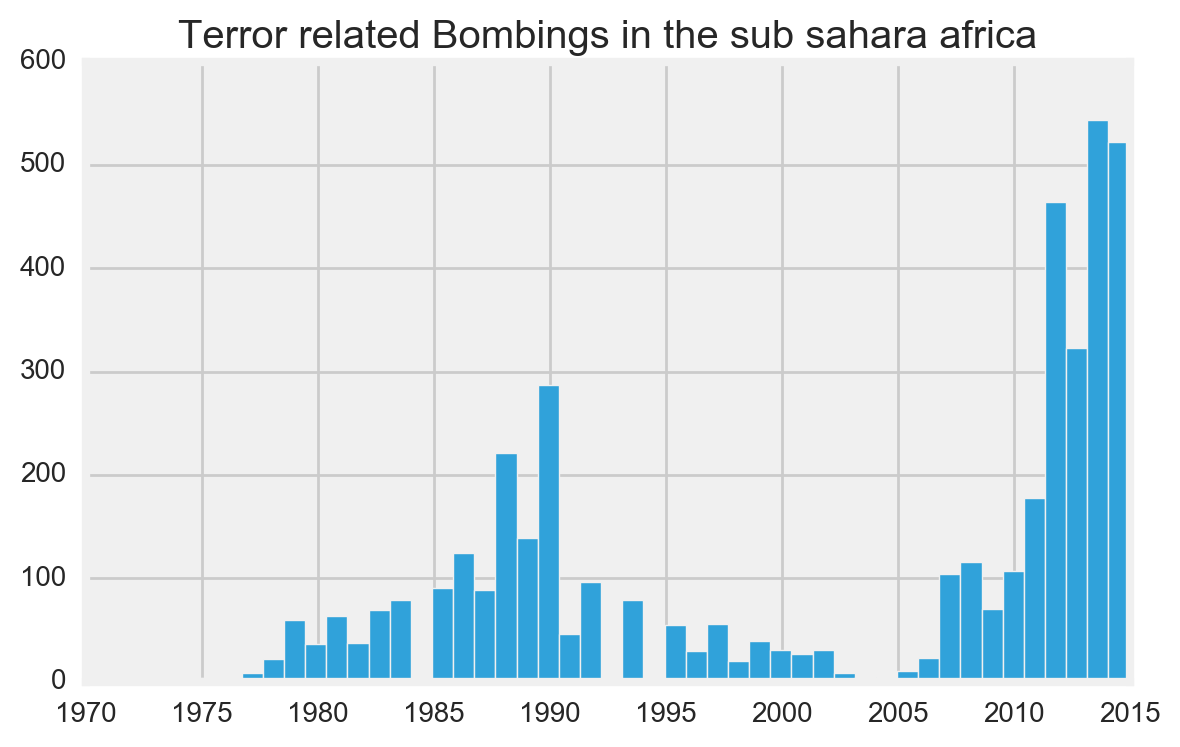

In [219]:
plt.hist(df[(df.attacktype1 ==3) & (df.region ==11)]['iyear'],bins = 45)
plt.title("Terror related Bombings in the sub sahara africa")
plt.show

<function matplotlib.pyplot.show>

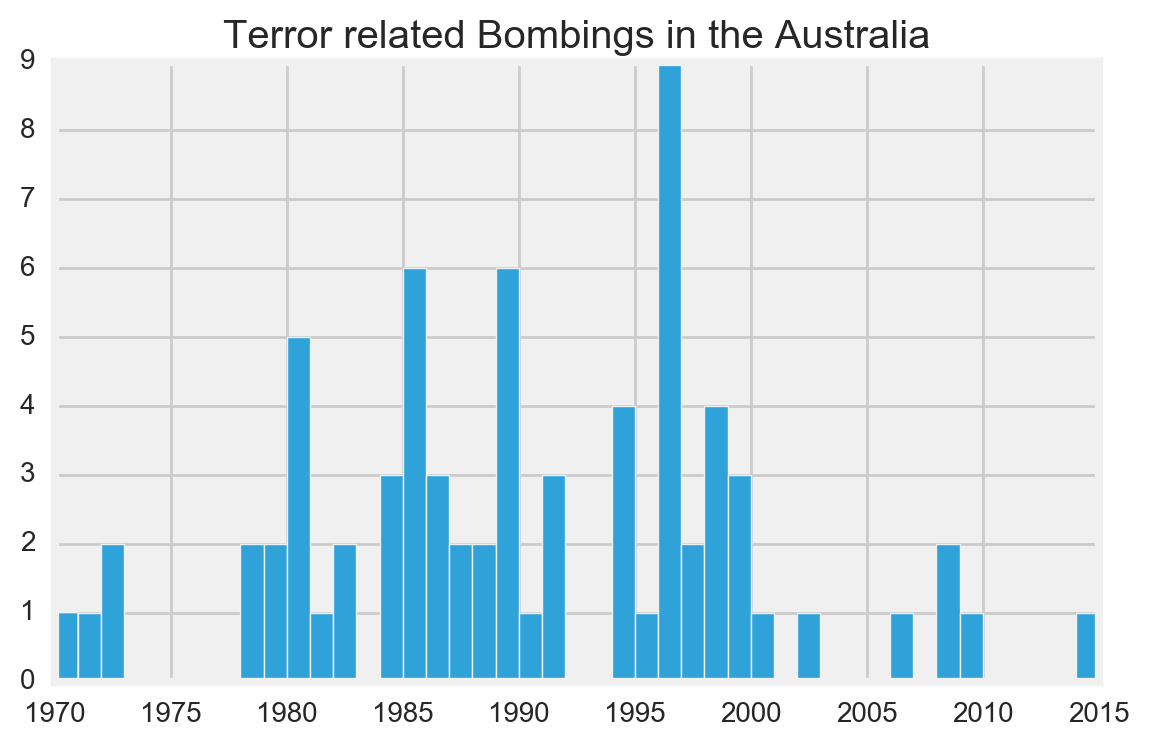

In [220]:
plt.hist(df[(df.attacktype1 ==3) & (df.region == 12)]['iyear'],bins = 45)
plt.title("Terror related Bombings in the Australia")
plt.show